In [44]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import QuantileTransformer, RobustScaler, PowerTransformer, MaxAbsScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import os
import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
TRAIN_DF = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
TEST_DF = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
# metric - AUC-ROC

# EDA

In [3]:
TRAIN_DF.info()
TEST_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         -----------

In [4]:
TRAIN_DF.shape[0] /365, TEST_DF.shape[0] /365

(6.0, 2.0)

In [5]:
TRAIN_DF.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


наборы охватывают 8 лет наблюдений, id - timestamp.

Валидация должна проводится как для временных рядов.

Заочно можно генерировать переменные сезона, месяца, недели

Сразу стоит сказать, что если добавлять сдвиг, то можно сделать не только факт дождя, но и количество дней с дождями за последние несколько дней.

In [6]:
TRAIN_DF = TRAIN_DF.set_index('id')
TEST_DF = TEST_DF.set_index('id')

In [7]:
TRAIN_DF

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1


In [8]:
def make_time_features(df):
    df['date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(df['day'] - 1, unit='D')
    df['week'] = (df['day'] - 1) // 7 + 1
    df['month'] = df['date'].dt.month
    # df['quarter'] = df['date'].dt.quarter
    df['quarter'] = 0
    df.loc[(df['month'] <= 2) | (df['month'] == 12), 'quarter'] = 1
    df.loc[(3 <= df['month']) & ( df['month'] <= 5), 'quarter'] = 2
    df.loc[(6 <= df['month']) & (df['month'] <= 8), 'quarter'] = 3
    df.loc[(9 <= df['month']) & (df['month'] <= 11), 'quarter'] = 4
    df['year'] = df.index // 365 + 1
    df.drop('date', axis=1, inplace=True)

make_time_features(TRAIN_DF)
make_time_features(TEST_DF)
# TRAIN_DF, TEST_DF

<Axes: xlabel='year', ylabel='rainfall'>

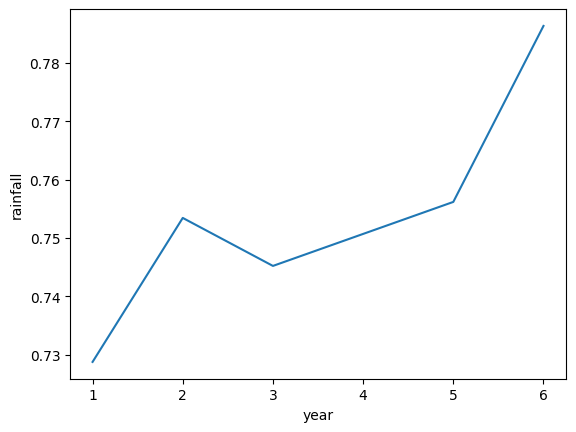

In [9]:
sns.lineplot(TRAIN_DF.groupby('year')['rainfall'].mean())

## Feature plots

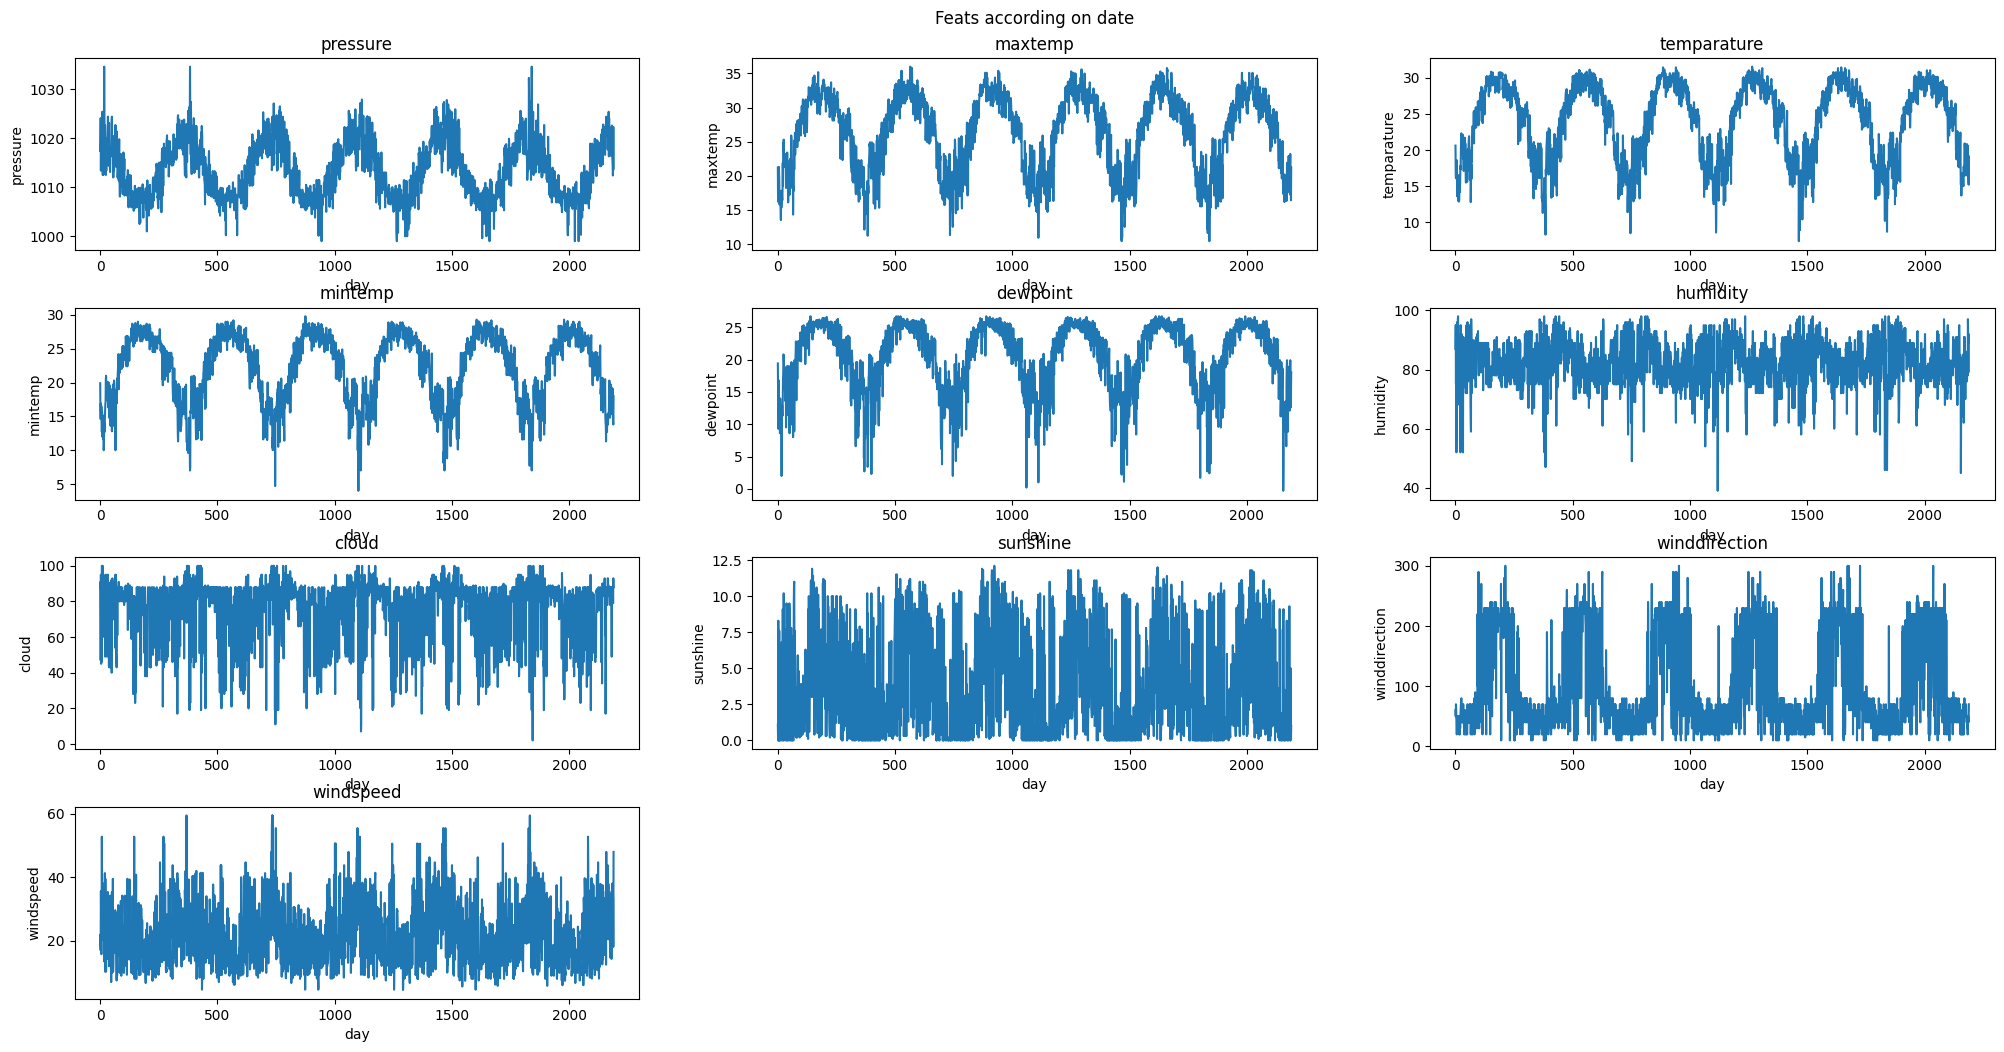

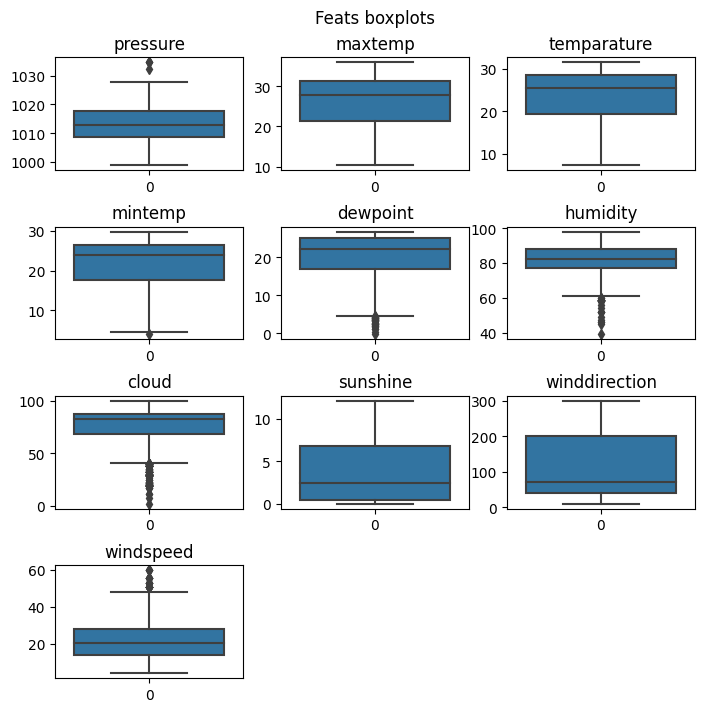

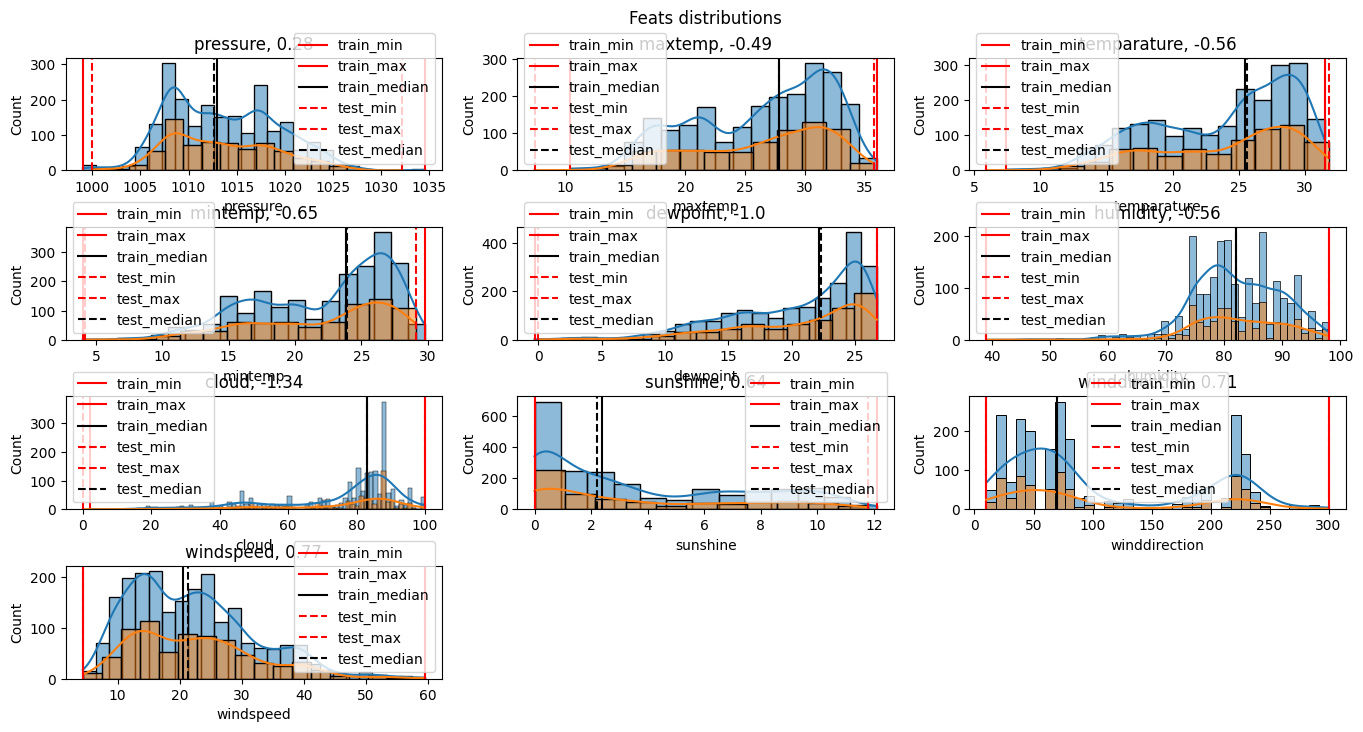

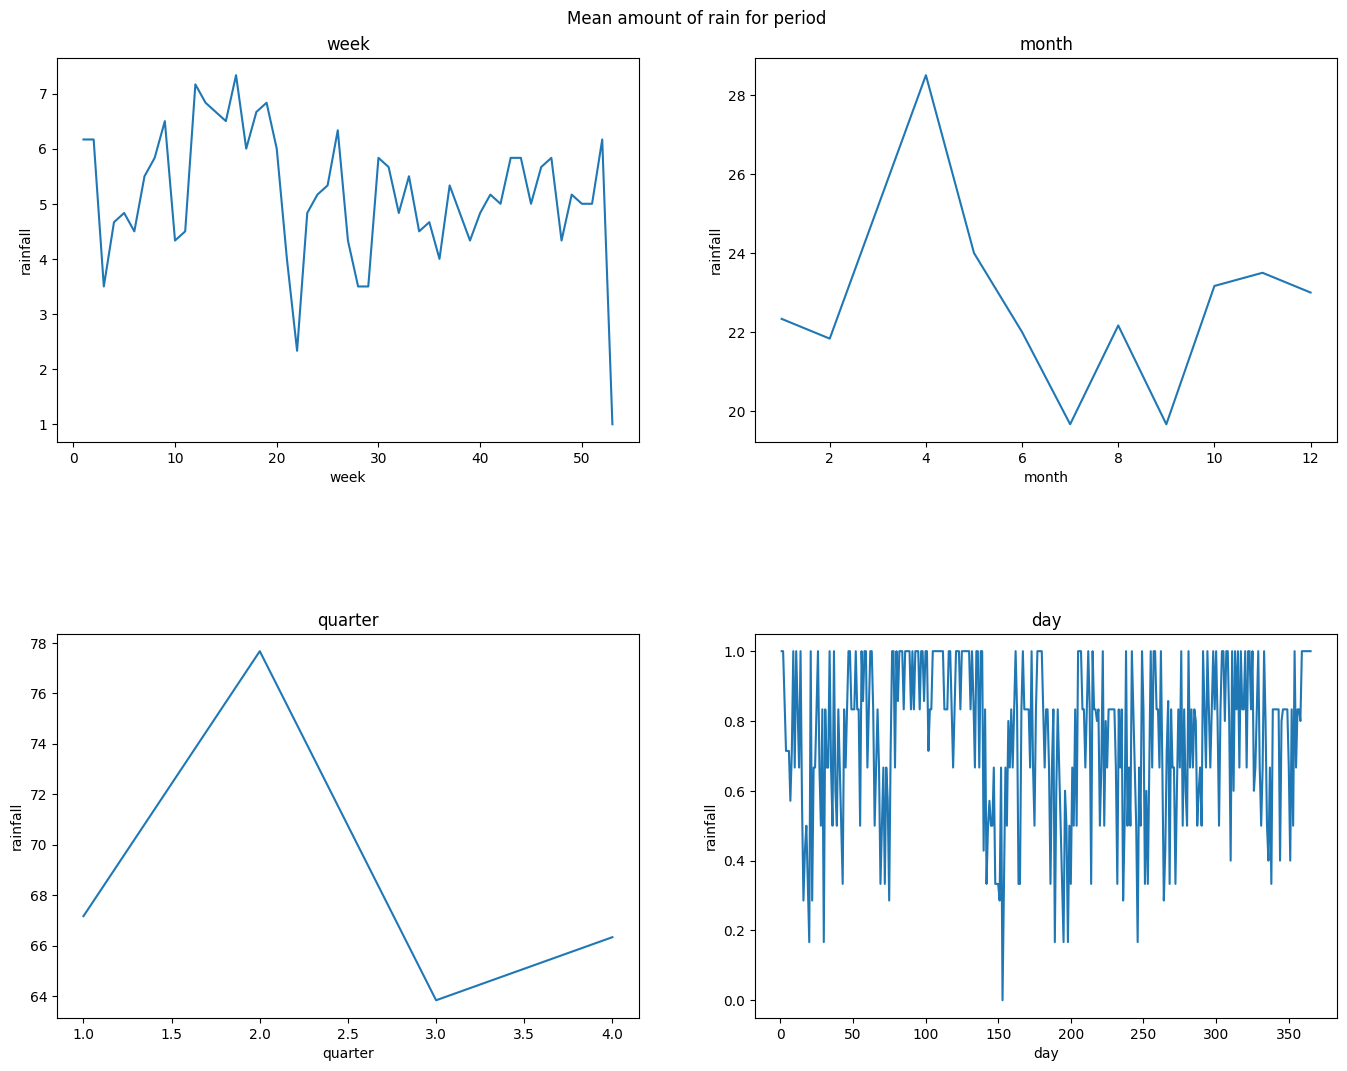

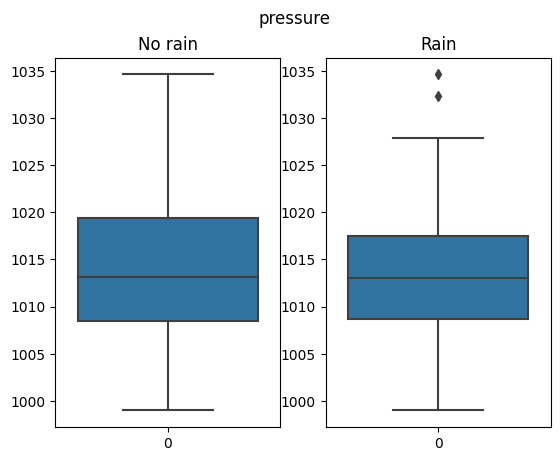

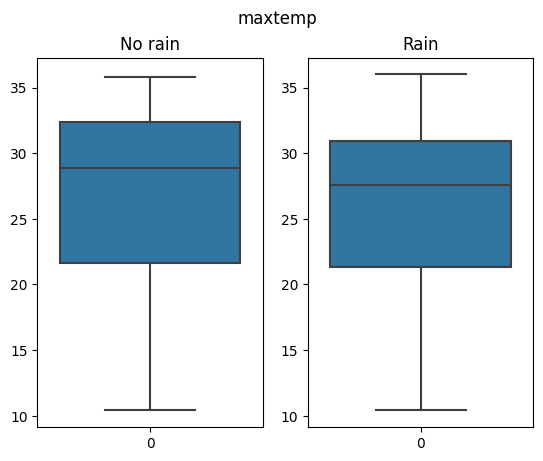

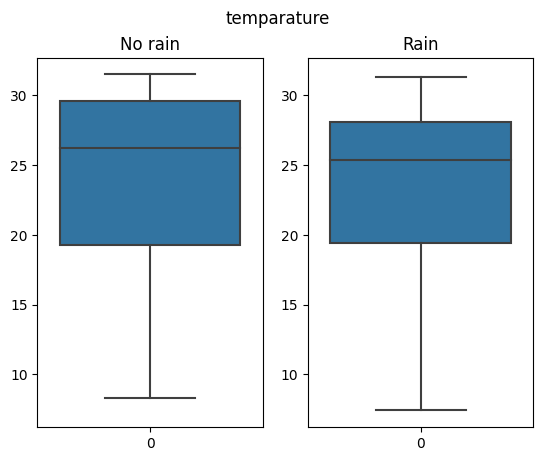

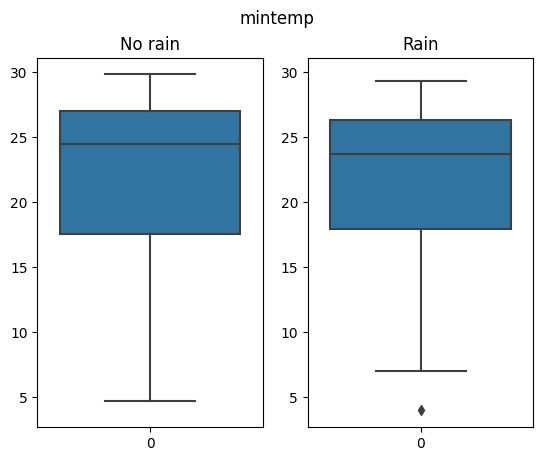

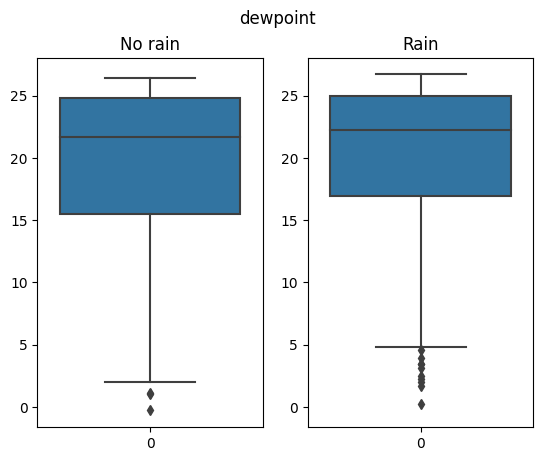

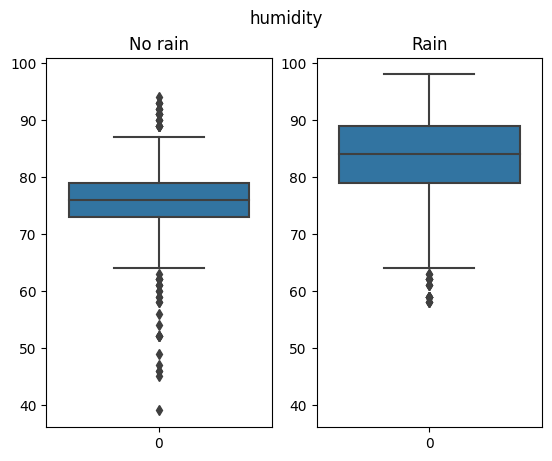

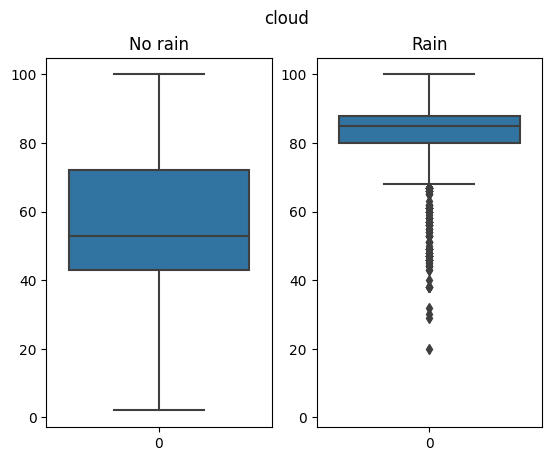

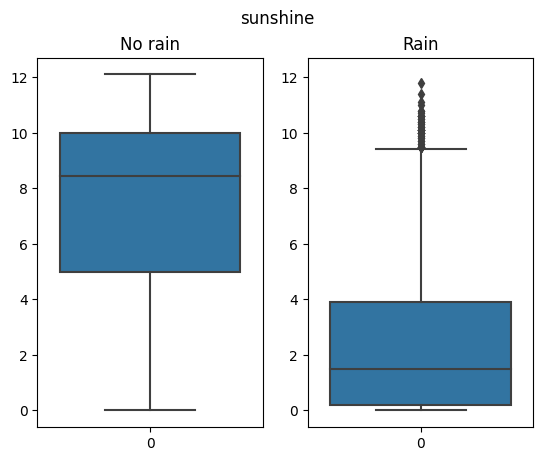

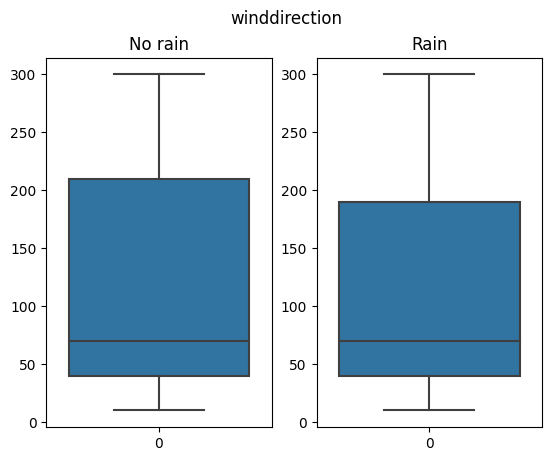

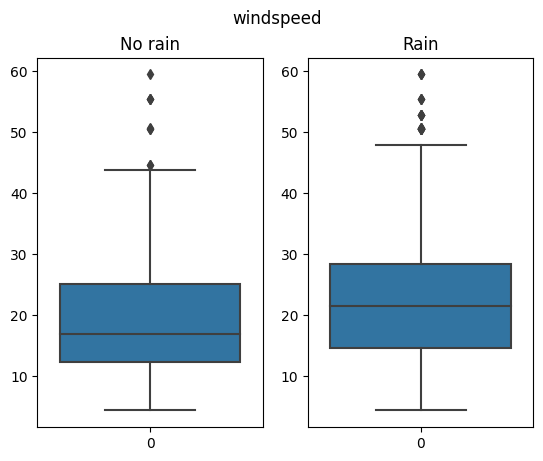

In [10]:
def digest(df, df_test=None, feats=None):
    if feats is None:
        feats = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
    
    # Feats according on date
    fig = plt.figure()
    plt.subplots_adjust(top=3, bottom=0,
                        left=0, right=3, hspace=0.3)
    for idx in range(len(feats)):
        axes = fig.add_subplot(6, 3, idx+1)
        sns.lineplot(df[feats[idx]])
        plt.xlabel('day')
        plt.title(feats[idx])
    plt.suptitle('Feats according on date', x=1.5, y=3.1)
    plt.show()

    # Feats boxplots
    fig = plt.figure()
    plt.subplots_adjust(top=2, bottom=0,
                        left=0, right=1, hspace=0.5)
    for idx in range(len(feats)):
        axes = fig.add_subplot(6, 3, idx+1)
        sns.boxplot(df[feats[idx]].values)
        plt.title(feats[idx])
    plt.suptitle('Feats boxplots', x=0.5, y=2.1)
    plt.show()

    # Feats distributions
    fig = plt.figure()
    plt.subplots_adjust(top=2, bottom=0,
                        left=0, right=2, 
                        hspace=0.5, wspace=0.2)
    for idx in range(len(feats)):
        axes = fig.add_subplot(6, 3, idx+1)

        train_feat = df[feats[idx]]
        if train_feat.nunique() > 100:
            sns.histplot(train_feat, kde=True)
        else:
            sns.histplot(train_feat, kde=True, bins=train_feat.nunique())

        
        train_min = train_feat.min()
        train_max = train_feat.max()
        train_median = train_feat.median()
        plt.axvline(x=train_min, c='red', label='train_min')
        plt.axvline(x=train_max, c='red', label='train_max')
        plt.axvline(x=train_median, c='black', label='train_median')

        if df_test is not None:
            test_feat = df_test[feats[idx]]
            test_min = test_feat.min()
            test_max = test_feat.max()
            test_median = test_feat.median()
        
            if train_feat.nunique() > 100:
                sns.histplot(test_feat, kde=True)
            else:
                sns.histplot(test_feat, kde=True, bins=train_feat.nunique())
            
            plt.axvline(x=test_min, c='red', ls='--', label='test_min')
            plt.axvline(x=test_max, c='red', ls='--', label='test_max')
            plt.axvline(x=test_median, c='black', ls='--', label='test_median')

        plt.legend()
        plt.title(f'{feats[idx]}, {round(train_feat.skew(), 2)}')
        
    plt.suptitle('Feats distributions', x=1, y=2.1)
    plt.show()

    time_feats = ['week', 'month', 'quarter']
    # Mean amount of rain for period
    fig = plt.figure()
    plt.subplots_adjust(top=2, bottom=0,
                        left=0, right=2, 
                        hspace=0.5, wspace=0.2)
    for idx in range(len(time_feats)):
        axes = fig.add_subplot(2, 2, idx+1)
        sns.lineplot(
            df
            .groupby(
                ['year', time_feats[idx]],
                as_index=False
            )['rainfall'].sum()
            .groupby(
                [time_feats[idx]]
            )['rainfall'].mean()
        )  
        
        plt.title(f'{time_feats[idx]}')
    plt.suptitle('Mean amount of rain for period', x=1, y=2.1)

    axes = fig.add_subplot(2, 2, 4)
    sns.lineplot(
        df.groupby('day')['rainfall'].mean()
    )
    plt.title('day')
    plt.show()

    # rain/no rain boxplot of groups
    for idx in range(len(feats)):
        fig = plt.figure()
        plt.suptitle(feats[idx])
        axes = fig.add_subplot(1, 2, 1)
        plt.title('No rain')
        sns.boxplot(
            df.loc[
                (df['rainfall']==0), feats[idx]
            ].reset_index(drop=True)
        )
        axes = fig.add_subplot(1, 2, 2, sharey=axes)
        plt.title('Rain')
        sns.boxplot(
            df.loc[
                (df['rainfall']==1), feats[idx]
            ].reset_index(drop=True)
        )
        plt.show()

digest(TRAIN_DF, TEST_DF)

In [11]:
# pd.pivot_table(TRAIN_DF, values=feats, index='rainfall', columns=['quarter'], aggfunc='mean').transpose()
# Во время дождя в среднем
# Облачность выше
# Точка росы выше
# Влажность выше
# Солнечность ниже
# Ветер сильнее

## Making some feats

In [12]:
scaler = RobustScaler()
# scaler = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=10)
scaler = PowerTransformer(method='yeo-johnson')
tmp = TRAIN_DF.copy()
# tmp = tmp.drop(['day', 'week', 'month', 'quarter', 'year', 'rainfall'], axis=1)
tmp = tmp.drop(['year', 'rainfall'], axis=1)
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(tmp)
tmp = scaler.fit_transform(tmp)
tmp = PCA(n_components=2).fit_transform(tmp)
tmp = pd.DataFrame(data=tmp, columns=['x', 'y'])
tmp['is_outlier'] = y_pred
tmp['rainfall'] = TRAIN_DF['rainfall']

fig = px.scatter(tmp, x="x", y="y", color='rainfall')
fig.show()
fig = px.scatter(tmp, x="x", y="y", color='is_outlier')
fig.show()


In [13]:
tmp = TRAIN_DF.copy()
tmp = tmp.drop(['year', 'rainfall'], axis=1)
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(tmp)
tmp['is_outlier'] = y_pred
tmp['rainfall'] = TRAIN_DF['rainfall']
print(tmp.loc[tmp['is_outlier'] == -1].shape)
print(tmp.loc[tmp['is_outlier'] == -1]['rainfall'].value_counts(normalize=True))
print(tmp.loc[tmp['is_outlier'] == 1]['rainfall'].value_counts(normalize=True))
# pd.pivot_table(
#     tmp, 
#     index=['is_outlier'], 
#     values=['pressure', 'maxtemp', 'temparature', 
#             'mintemp', 'dewpoint', 'humidity', 
#             'cloud', 'sunshine', 'winddirection', 
#             'windspeed'
#            ], 
#     aggfunc=['mean', 'median']
# )

(28, 16)
rainfall
1    0.821429
0    0.178571
Name: proportion, dtype: float64
rainfall
1    0.752544
0    0.247456
Name: proportion, dtype: float64


Промежуточные выводы:

    2. Влажность, признаким ветра, солнечность и облачность - зашумлены.

    3. некторые признаки могут иметь высокую корреляцию между собой

    4. Не для всех столбцов можно использовать один и тот же трансформер.

    5. снижение размерности после препроцессинга выделяет несколько скоплений дождливых дней + некоторые трансформации поляризуют классы внутри скоплений.
        Вполне возможно дождь - результат предельных значений некоторых признаков.

    6. весна - наиболее дождливый сезон
Следующие шаги:

    0. Проверка некоторых предельных значений (групп) - проверка баланса классов для таких значений.
        Детальный анализ затруднителен, т.к. выбросов не очень много, но те, что есть дают понять, что смещение идет в сторону дождя(минимально убеждающее).
        
    1. Дождь может быть сдвинут на 1-2 дня (зачастую на 1). Можно попробывать проверить автокорреляцию.
    - минус такого подхода - накопительная ошибка.
        есть предпосылки
        
    3. Объединение признаков и их преобразование.

Делаем сдвиг на два дня. добавляем все признаки, что бы проверить динумику этих параметров.

In [14]:
tmp = TRAIN_DF.copy()
# print(tmp.head(3))
# print(tmp.shift(2).head(3))
# Можно было бы проверить в зависимости от периода, но это пока рано
tmp = tmp.drop(['day', 'week', 'month', 'quarter', 'year'], axis=1)
tmp1 = tmp.shift(1)
# tmp2 = tmp.shift(2)
tmp1 = tmp1.rename(columns={column : column + '_previous' for column in tmp1.columns})
# tmp2 = tmp2.rename(columns={column : column + '_2' for column in tmp2.columns})
tmp = pd.concat([tmp, tmp1], axis=1).drop([0])
cols = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'winddirection', 'windspeed']
# Т.к. нам нужно отслеживать динамику, то берем еще и дельту
# Есть 4 случая 00, 01, 10, 11 для 1го сдвига - это группировка
for col in cols:
    tmp[col + '_delta'] = tmp[col] - tmp[col + '_previous']
    
means_deltas = tmp.groupby(['rainfall_previous', 'rainfall'])[[col + '_delta' for col in cols]].agg('median').add_suffix('_median')
vars_deltas = tmp.groupby(['rainfall_previous', 'rainfall'])[[col + '_delta' for col in cols]].agg('var').add_suffix('_var')
sizes = tmp[['rainfall', 'rainfall_previous']].value_counts()
tmp1 = means_deltas.join(vars_deltas, how='left')
tmp1 = tmp1.join(sizes, how='left')
tmp1.transpose()

rainfall_previous                   0.0                       1.0             
rainfall                              0            1            0            1
pressure_delta_median          0.000000    -0.900000     0.600000    -0.100000
maxtemp_delta_median           0.300000    -0.400000     0.200000     0.000000
temparature_delta_median       0.100000    -0.100000     0.100000     0.000000
mintemp_delta_median           0.000000     0.000000     0.100000     0.000000
dewpoint_delta_median          0.100000     0.800000    -0.900000     0.000000
humidity_delta_median          1.000000     6.000000    -6.000000     0.000000
cloud_delta_median             1.000000    24.000000   -22.000000     0.000000
sunshine_delta_median          0.000000    -3.600000     3.800000     0.000000
winddirection_delta_median     0.000000     0.000000     0.000000     0.000000
windspeed_delta_median        -0.300000     2.900000    -2.200000     0.000000
pressure_delta_var            14.603563    15.350695    13.034836    14.007406
maxtemp_delta_var              6.591767     7.573002     6.414620     6.396366
temparature_delta_var          5.478194     5.563420     4.131322     4.521983
mintemp_delta_var              5.908510     5.829496     4.178794     4.689193
dewpoint_delta_var            15.168044    11.083508     9.875936     7.821980
humidity_delta_var            75.756713    98.145538   101.258128    73.818952
cloud_delta_var              586.940141   504.697254   505.757855   169.598813
sunshine_delta_var            12.819002    16.886424    16.540809    10.997286
winddirection_delta_var     8616.336036  5811.222396  6830.210211  5042.589113
windspeed_delta_var          152.772317   167.547480   162.522488   148.446544
count                        187.000000   353.000000   353.000000  1296.000000

Проявились достаточно интересные особенности.

Самое главное это размер групп:

- если сейчас идет дождь, то вчера 4:1 был дождь (0.8)

- если сейчас не идет дождь, то вчера 2:1 был дождь (0.66)
    
(похожие числа и сам факт такого наблюдения могут вызвать не доверие, но все сделано корректно, кроме того, среднее количество дождя в день за 6 лет около 0.75 с разбросом,      т.е. достаточно дождливый регион)

Таким образом, наличие наличие исторического столбаци может сильно повлиять на предсказание. Далее имеет смысл рассмотреть дельты признаков, и рассмотреть группы по подробнее.

pressure_delta - давление не меняется когда погода остается прежней, растет при 01, падает при 10
maxtemp_delta - аналогично
temparature_delta - менее выражено
mintemp_delta - не выражено
dewpoint_delta - выражено
humidity_delta - сильно выражено (очевидно же)
cloud_delta - выражено, но когда дождя не было и нет среднее дельты выше (т.е. облачка потихоньку нагоняются)
sunshine_delta - выражено
winddirection_delta - выражено, но не очевидно
windspeed_delta - выраженно (ветер меняет погоду).

Таким образом замена признаков на дельты могло бы внести свой вклад (или простое добавление дельт). Вопрос с зависимыми признаками не решен (например, клауд и саншайн).

winddirection - показывает направление ветра по азимуту и боксплоты в целом похожи обеих групп (т.е. есть предположение о бесполезности этого признака).
В контексте генерации признаков дельта для нас не особо полезна, куда важнее направление текущего ветра (из облачного региона или нет)

Текущее дествие проверить, значимы ли различия групп по признаком, те дельты, которые значимы будут включены в выборку.
Кроме того, наличие нескольких таких дельт снизит потребность в историческом классе и все признаки будут "достоверны" (т.е. не будет накопления ошибки).
    
    Иначе если дождя не было, то поставит дождь (если брать только этот фактор), а дальше будет ставить дождь еще чаще.

In [15]:
# Тест Краскела-Уоллиса для признаков
from scipy.stats import kruskal
# H_0 - медианы равны <0.05 откланяем в пользу альтернативы H_1
for col in cols:
    col += '_delta'
    _00 = tmp.loc[(tmp['rainfall'] == 0) & (tmp['rainfall_previous'] == 0), col]
    _01 = tmp.loc[(tmp['rainfall'] == 0) & (tmp['rainfall_previous'] == 1), col]
    _10 = tmp.loc[(tmp['rainfall'] == 1) & (tmp['rainfall_previous'] == 0), col]
    _11 = tmp.loc[(tmp['rainfall'] == 1) & (tmp['rainfall_previous'] == 1), col]
    p_value = kruskal(_00, _01, _10, _11).pvalue
    if p_value <= .05:
        print(f'Отвергаем {col}')
    else:
        print(f'Не отвергаем {col}')

# Признаки связанные с температурой не берем

Отвергаем pressure_delta
Отвергаем maxtemp_delta
Не отвергаем temparature_delta
Не отвергаем mintemp_delta
Отвергаем dewpoint_delta
Отвергаем humidity_delta
Отвергаем cloud_delta
Отвергаем sunshine_delta
Отвергаем winddirection_delta
Отвергаем windspeed_delta


Дельта может понять будет ли дождь или нет, если статус меняется.
Если статус дождя не меняется - идем дальше

In [16]:
viz_tmp = tmp[cols].copy()

viz_tmp = TSNE(n_components=2).fit_transform(RobustScaler().fit_transform(viz_tmp))

viz_tmp = pd.DataFrame(data=viz_tmp, columns=['x', 'y'])
viz_tmp['rainfall_group'] = tmp['rainfall'].apply(str) + tmp['rainfall_previous'].apply(int).apply(str)

viz_tmp = viz_tmp.loc[
    (viz_tmp['rainfall_group'] == '00') | (viz_tmp['rainfall_group'] == '11')
]
fig = px.scatter(viz_tmp, x="x", y="y", color='rainfall_group')
fig.show()
# Снежение размерности показывает, что группа 00 имеет место концентрации (11 распределена по всей области)

In [17]:
viz_tmp = tmp[cols].copy()

viz_tmp['rainfall_group'] = tmp['rainfall'].apply(str) + tmp['rainfall_previous'].apply(int).apply(str)

viz_tmp = viz_tmp.loc[
    (viz_tmp['rainfall_group'] == '00') | (viz_tmp['rainfall_group'] == '11')
]
print(viz_tmp.groupby('rainfall_group').agg(['median', 'mean']).transpose().round(2))

# Проверяем равенство медиан самих признаков двух оставшихся групп
for col in cols:
    _00 = viz_tmp.loc[viz_tmp['rainfall_group'] == '00', col]
    _11 = viz_tmp.loc[viz_tmp['rainfall_group'] == '11', col]
    p_value = kruskal(_00, _11).pvalue
    if p_value <= .05:
        print(f'Отвергаем {col}')
    else:
        print(f'Не отвергаем {col}')

# Основными фактором будет являться солнечность, облачность и влажность

rainfall_group             00       11
pressure      median  1011.50  1013.00
              mean    1013.42  1013.45
maxtemp       median    30.30    27.50
              mean      27.84    26.02
temparature   median    27.90    25.30
              mean      24.95    23.76
mintemp       median    25.60    23.70
              mean      22.89    22.08
dewpoint      median    23.20    22.20
              mean      20.28    20.70
humidity      median    77.00    84.00
              mean      76.01    84.35
cloud         median    53.00    85.00
              mean      54.62    82.90
sunshine      median     9.10     1.35
              mean       7.67     2.46
winddirection median    70.00    70.00
              mean     118.66   104.59
windspeed     median    16.20    21.50
              mean      19.19    22.36
Не отвергаем pressure
Отвергаем maxtemp
Отвергаем temparature
Отвергаем mintemp
Не отвергаем dewpoint
Отвергаем humidity
Отвергаем cloud
Отвергаем sunshine
Не отвергаем winddirectio

Имеет смысл добавить дельты признаков

pressure_delta, maxtemp_delta, dewpoint_delta, humidity_delta,
cloud_delta, sunshine_delta, windspeed_delta

## Выбор трансформеров

Во первых наблюдается бимодальность давления и признаков температуры - это скорее всего из-за зимы 

- надо проверить (двление зимой обычно повышенное)
- (гистограммы похожи на зеркальные)

В целом проблемы будут только с солнечностью (около дискретная) и с азимутом (много обрывов)

- азимут также бимодален, возможно зимой другой направление ветра

в контексте обучения бимодальность может оказать влияние (даже если триада важных основных признаков будет иметь достаточно ввысокую важность)

In [18]:
# Выяснение причин бимодальности

# В принципе наму нужна для подтверждения гипотезы пределные сезоны (зима-лето)
TRAIN_DF.groupby('quarter')[['pressure', 'maxtemp', 'temparature', 'mintemp']].agg(['min', 'max', 'median', 'mean']).transpose().round(2)

quarter                   1        2        3        4
pressure    min     1002.50  1004.20   999.00  1004.90
            max     1034.60  1023.80  1015.00  1025.90
            median  1019.40  1011.40  1008.30  1016.40
            mean    1019.17  1011.93  1008.02  1015.47
maxtemp     min       10.40    14.30    27.70    16.20
            max       33.00    34.40    36.00    32.80
            median    19.40    28.00    32.00    27.20
            mean      19.46    27.41    31.98    26.49
temparature min        7.40    12.80    25.80    13.20
            max       30.10    30.80    31.50    29.80
            median    17.50    25.80    29.20    25.10
            mean      17.49    25.03    29.10    24.09
mintemp     min        4.00    10.00    24.50    11.30
            max       27.80    29.80    29.30    28.10
            median    15.90    24.20    26.90    23.40
            mean      15.92    23.30    27.01    22.35

In [19]:
TRAIN_DF.loc[TRAIN_DF['quarter'] == 1, 'winddirection'].value_counts().head(5), TRAIN_DF.loc[TRAIN_DF['quarter'] == 3, 'winddirection'].value_counts().head(5)

(winddirection
 20.0    133
 50.0     99
 40.0     97
 70.0     77
 60.0     62
 Name: count, dtype: int64,
 winddirection
 220.0    143
 230.0     82
 200.0     32
 240.0     29
 190.0     26
 Name: count, dtype: int64)

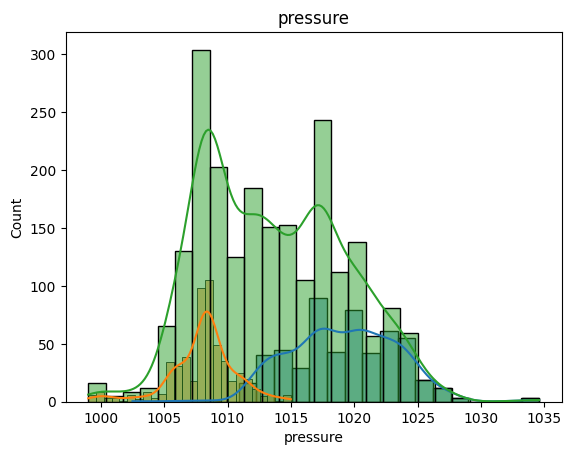

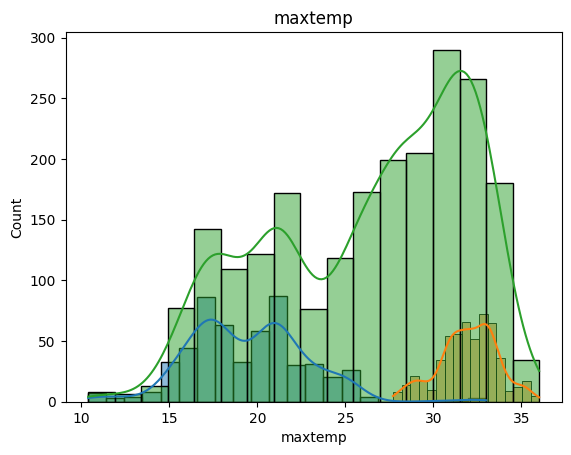

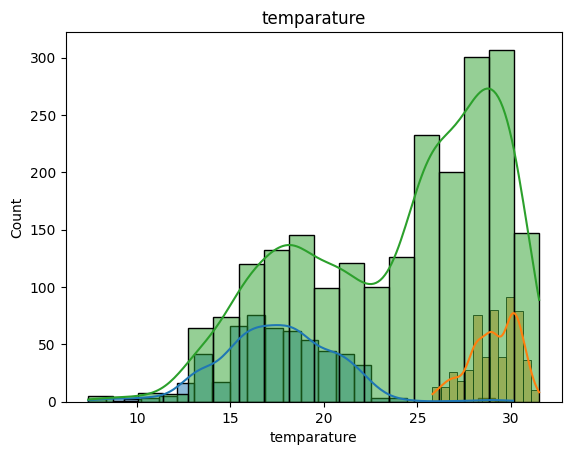

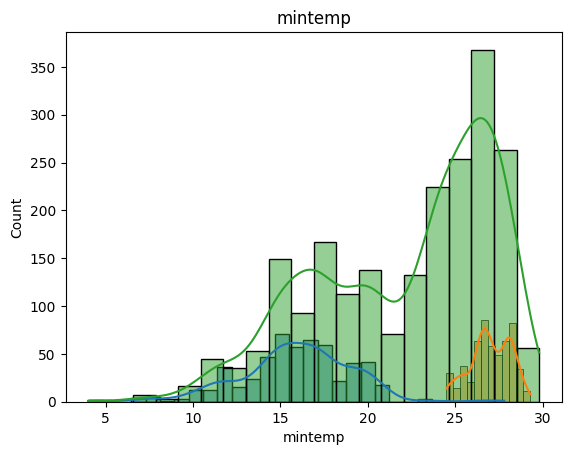

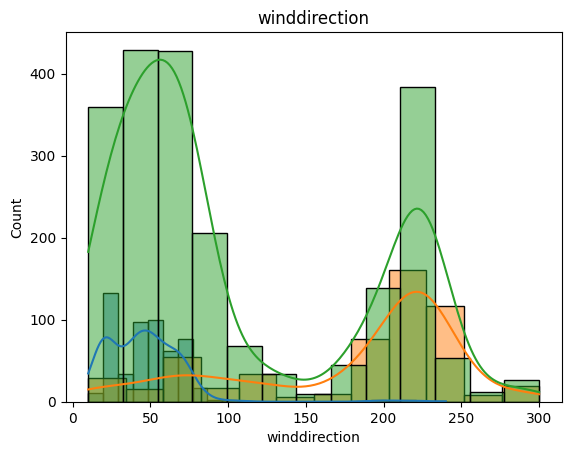

In [20]:
sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 1, 'pressure'], kde=True)
sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 3, 'pressure'], kde=True)
sns.histplot(TRAIN_DF['pressure'], kde=True)
plt.title('pressure')
plt.show()

sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 1, 'maxtemp'], kde=True)
sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 3, 'maxtemp'], kde=True)
sns.histplot(TRAIN_DF['maxtemp'], kde=True)
plt.title('maxtemp')
plt.show()

sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 1, 'temparature'], kde=True)
sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 3, 'temparature'], kde=True)
sns.histplot(TRAIN_DF['temparature'], kde=True)
plt.title('temparature')
plt.show()

sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 1, 'mintemp'], kde=True)
sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 3, 'mintemp'], kde=True)
sns.histplot(TRAIN_DF['mintemp'], kde=True)
plt.title('mintemp')
plt.show()

sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 1, 'winddirection'], kde=True)
sns.histplot(TRAIN_DF.loc[TRAIN_DF['quarter'] == 3, 'winddirection'], kde=True)
sns.histplot(TRAIN_DF['winddirection'], kde=True)
plt.title('winddirection')
plt.show()

Предположение для всех признаков подтвердилось, индиктором моды уже является сезон (для в)

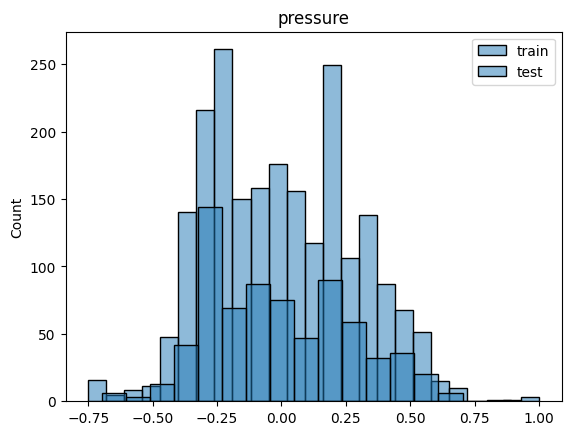

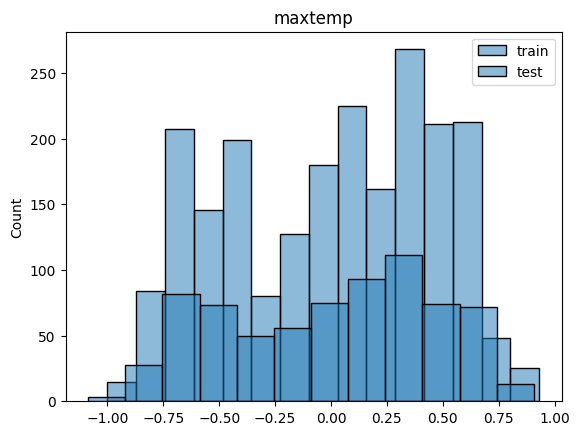

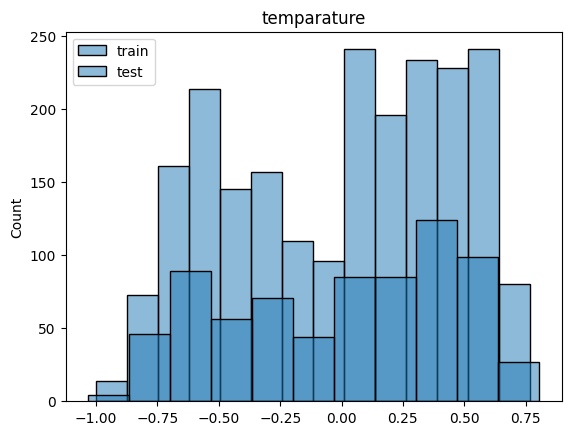

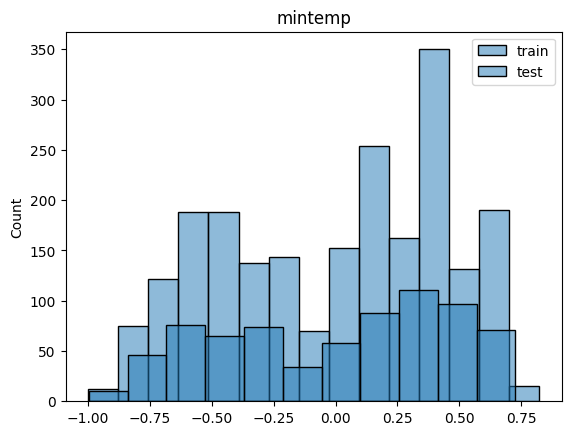

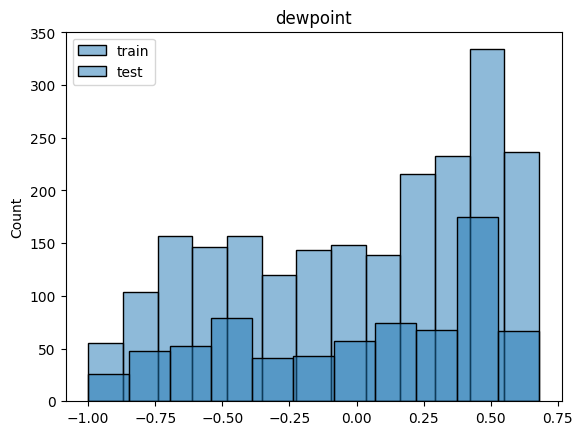

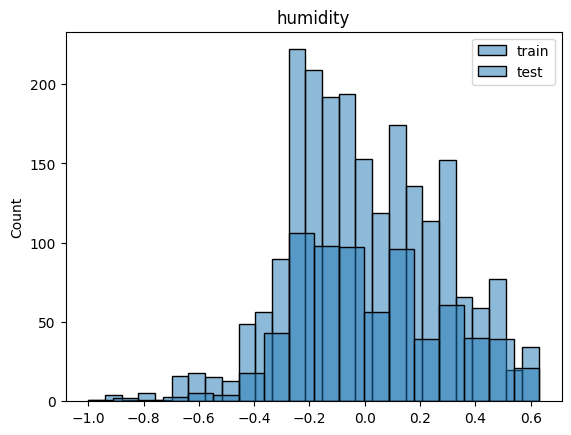

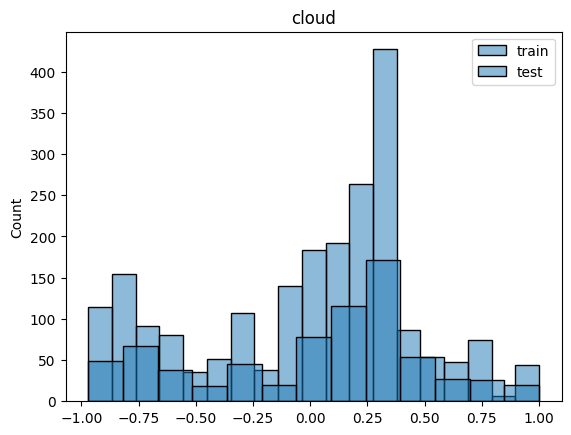

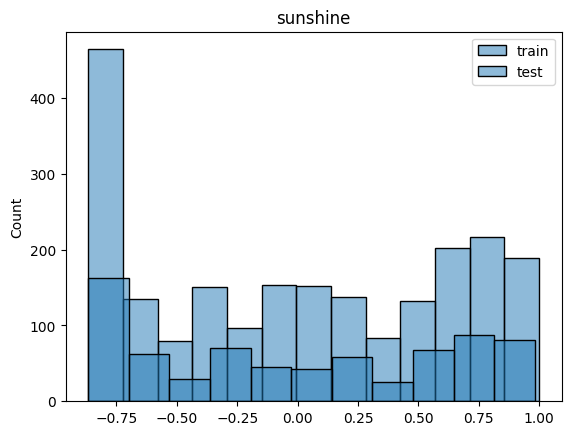

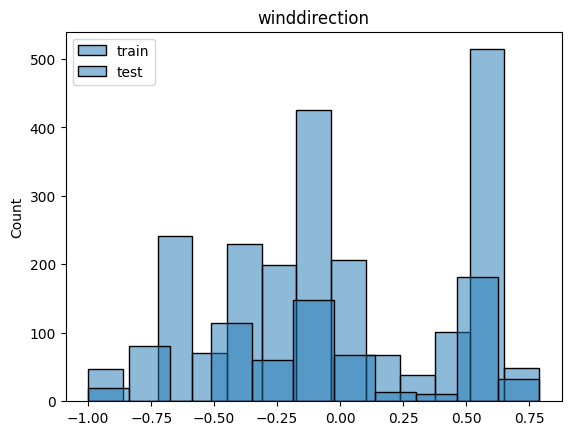

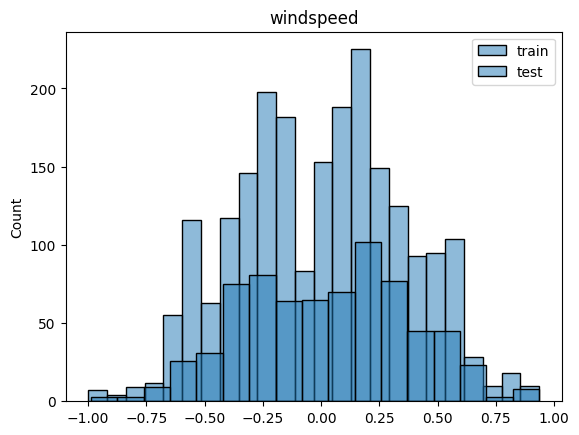

In [21]:
# Бимодальность(мульти-) является большой проблемой т.к. нужно следить за границами признаков
# Кроме того, выбор преобразования будет производиться с оглядкой на тестовые данные, т.к. некоторые признаки могут быть вне диапазнона
# Распределение признаков относительно одинаковые для обоих наборов
# ! генерация признаков должна происходить до преобразования
feats = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

for feat in feats:
    YJ_scaler = PowerTransformer(method='yeo-johnson')

    MA_scaler = MaxAbsScaler()
    train_feat = pd.DataFrame(TRAIN_DF[feat])
    test_feat = pd.DataFrame(TEST_DF[feat])
    
    train_feat = YJ_scaler.fit_transform(train_feat)
    test_feat = YJ_scaler.transform(test_feat)

    train_feat = MA_scaler.fit_transform(train_feat)
    test_feat = MA_scaler.transform(test_feat)

    sns.histplot(train_feat, label='train')
    sns.histplot(test_feat, label='test')
    plt.legend()
    plt.title(feat)
    plt.show()

<Axes: ylabel='Count'>

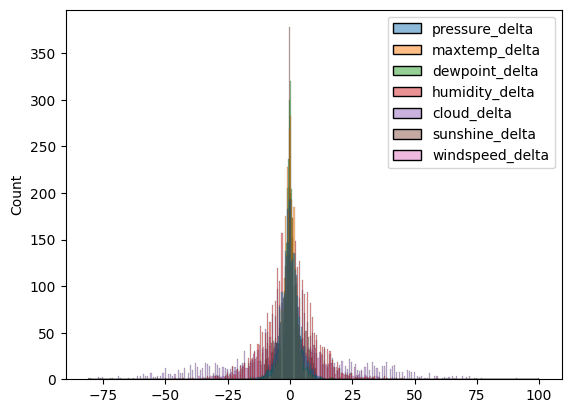

In [22]:
# Генерирование признаков, анализ их распределений

# delta pressure_delta, maxtemp_delta, dewpoint_delta, humidity_delta, cloud_delta, sunshine_delta, windspeed_delta

cols = ['pressure', 'maxtemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
len_train = TRAIN_DF.shape[0]

tmp = pd.concat([TRAIN_DF, TEST_DF])

tmp = tmp[cols]
tmp_shifted = tmp.shift(1)

tmp_shifted = tmp_shifted.add_suffix('_previous')

tmp = pd.concat([tmp, tmp_shifted], axis=1).drop([0])

for col in cols:
    tmp[col + '_delta'] = tmp[col] - tmp[col + '_previous']

tmp = tmp.drop(cols + [col  + '_previous' for col in cols],axis=1)
tmp
sns.histplot(tmp)
# новые признаки около нормальные, остается привести к диапазону [-1, 1], т.к. разные хвосты и знак критически важен.

In [23]:
tmp.median(), tmp.mean()

(pressure_delta     0.0
 maxtemp_delta      0.0
 dewpoint_delta     0.0
 humidity_delta     0.0
 cloud_delta        0.0
 sunshine_delta     0.0
 windspeed_delta    0.0
 dtype: float64,
 pressure_delta     0.001199
 maxtemp_delta      0.000343
 dewpoint_delta    -0.002090
 humidity_delta    -0.002741
 cloud_delta        0.000343
 sunshine_delta    -0.000308
 windspeed_delta    0.011442
 dtype: float64)

In [24]:
train_deltas = tmp.iloc[:len_train-1]
test_deltas = tmp.iloc[len_train-1:]
train_deltas.shape, test_deltas.shape

((2189, 7), (730, 7))

In [25]:
TRAIN_DF = TRAIN_DF.drop(0)
TRAIN_DF = pd.concat([TRAIN_DF, train_deltas], axis=1)
TEST_DF = pd.concat([TEST_DF, test_deltas], axis=1)

In [26]:
cols_for_minmax_scaler = ['day', 'week', 'month', 'quarter', 'year']
cols_for_YJ_scaler = [
                        'pressure', 'maxtemp', 'temparature', 
                        'mintemp', 'dewpoint', 'humidity', 
                        'cloud', 'sunshine', 'winddirection', 
                        'windspeed'
                     ]
cols_for_maxabs_scaler = [
                            'pressure_delta', 'maxtemp_delta', 'dewpoint_delta', 
                            'humidity_delta', 'cloud_delta', 'sunshine_delta', 
                            'windspeed_delta'
                        ]

In [27]:
TRAIN_DF_copy = TRAIN_DF.copy()
TEST_DF_copy = TEST_DF.copy()

MM_scaler = MinMaxScaler()
MA_scaler = MaxAbsScaler()
YJ_scaler_pipline = Pipeline(
                                [
                                    ('YJ_transformer', PowerTransformer(method='yeo-johnson')),
                                    ('MA_scaler', MaxAbsScaler())
                                ]
                            )
TRAIN_DF_copy[cols_for_minmax_scaler] = MM_scaler.fit_transform(TRAIN_DF_copy[cols_for_minmax_scaler])
TRAIN_DF_copy[cols_for_YJ_scaler]     = YJ_scaler_pipline.fit_transform(TRAIN_DF_copy[cols_for_YJ_scaler])
TRAIN_DF_copy[cols_for_maxabs_scaler] = MA_scaler.fit_transform(TRAIN_DF_copy[cols_for_maxabs_scaler])

TEST_DF_copy[cols_for_minmax_scaler] = MM_scaler.transform(TEST_DF_copy[cols_for_minmax_scaler])
TEST_DF_copy[cols_for_YJ_scaler]     = YJ_scaler_pipline.transform(TEST_DF_copy[cols_for_YJ_scaler])
TEST_DF_copy[cols_for_maxabs_scaler] = MA_scaler.transform(TEST_DF_copy[cols_for_maxabs_scaler])

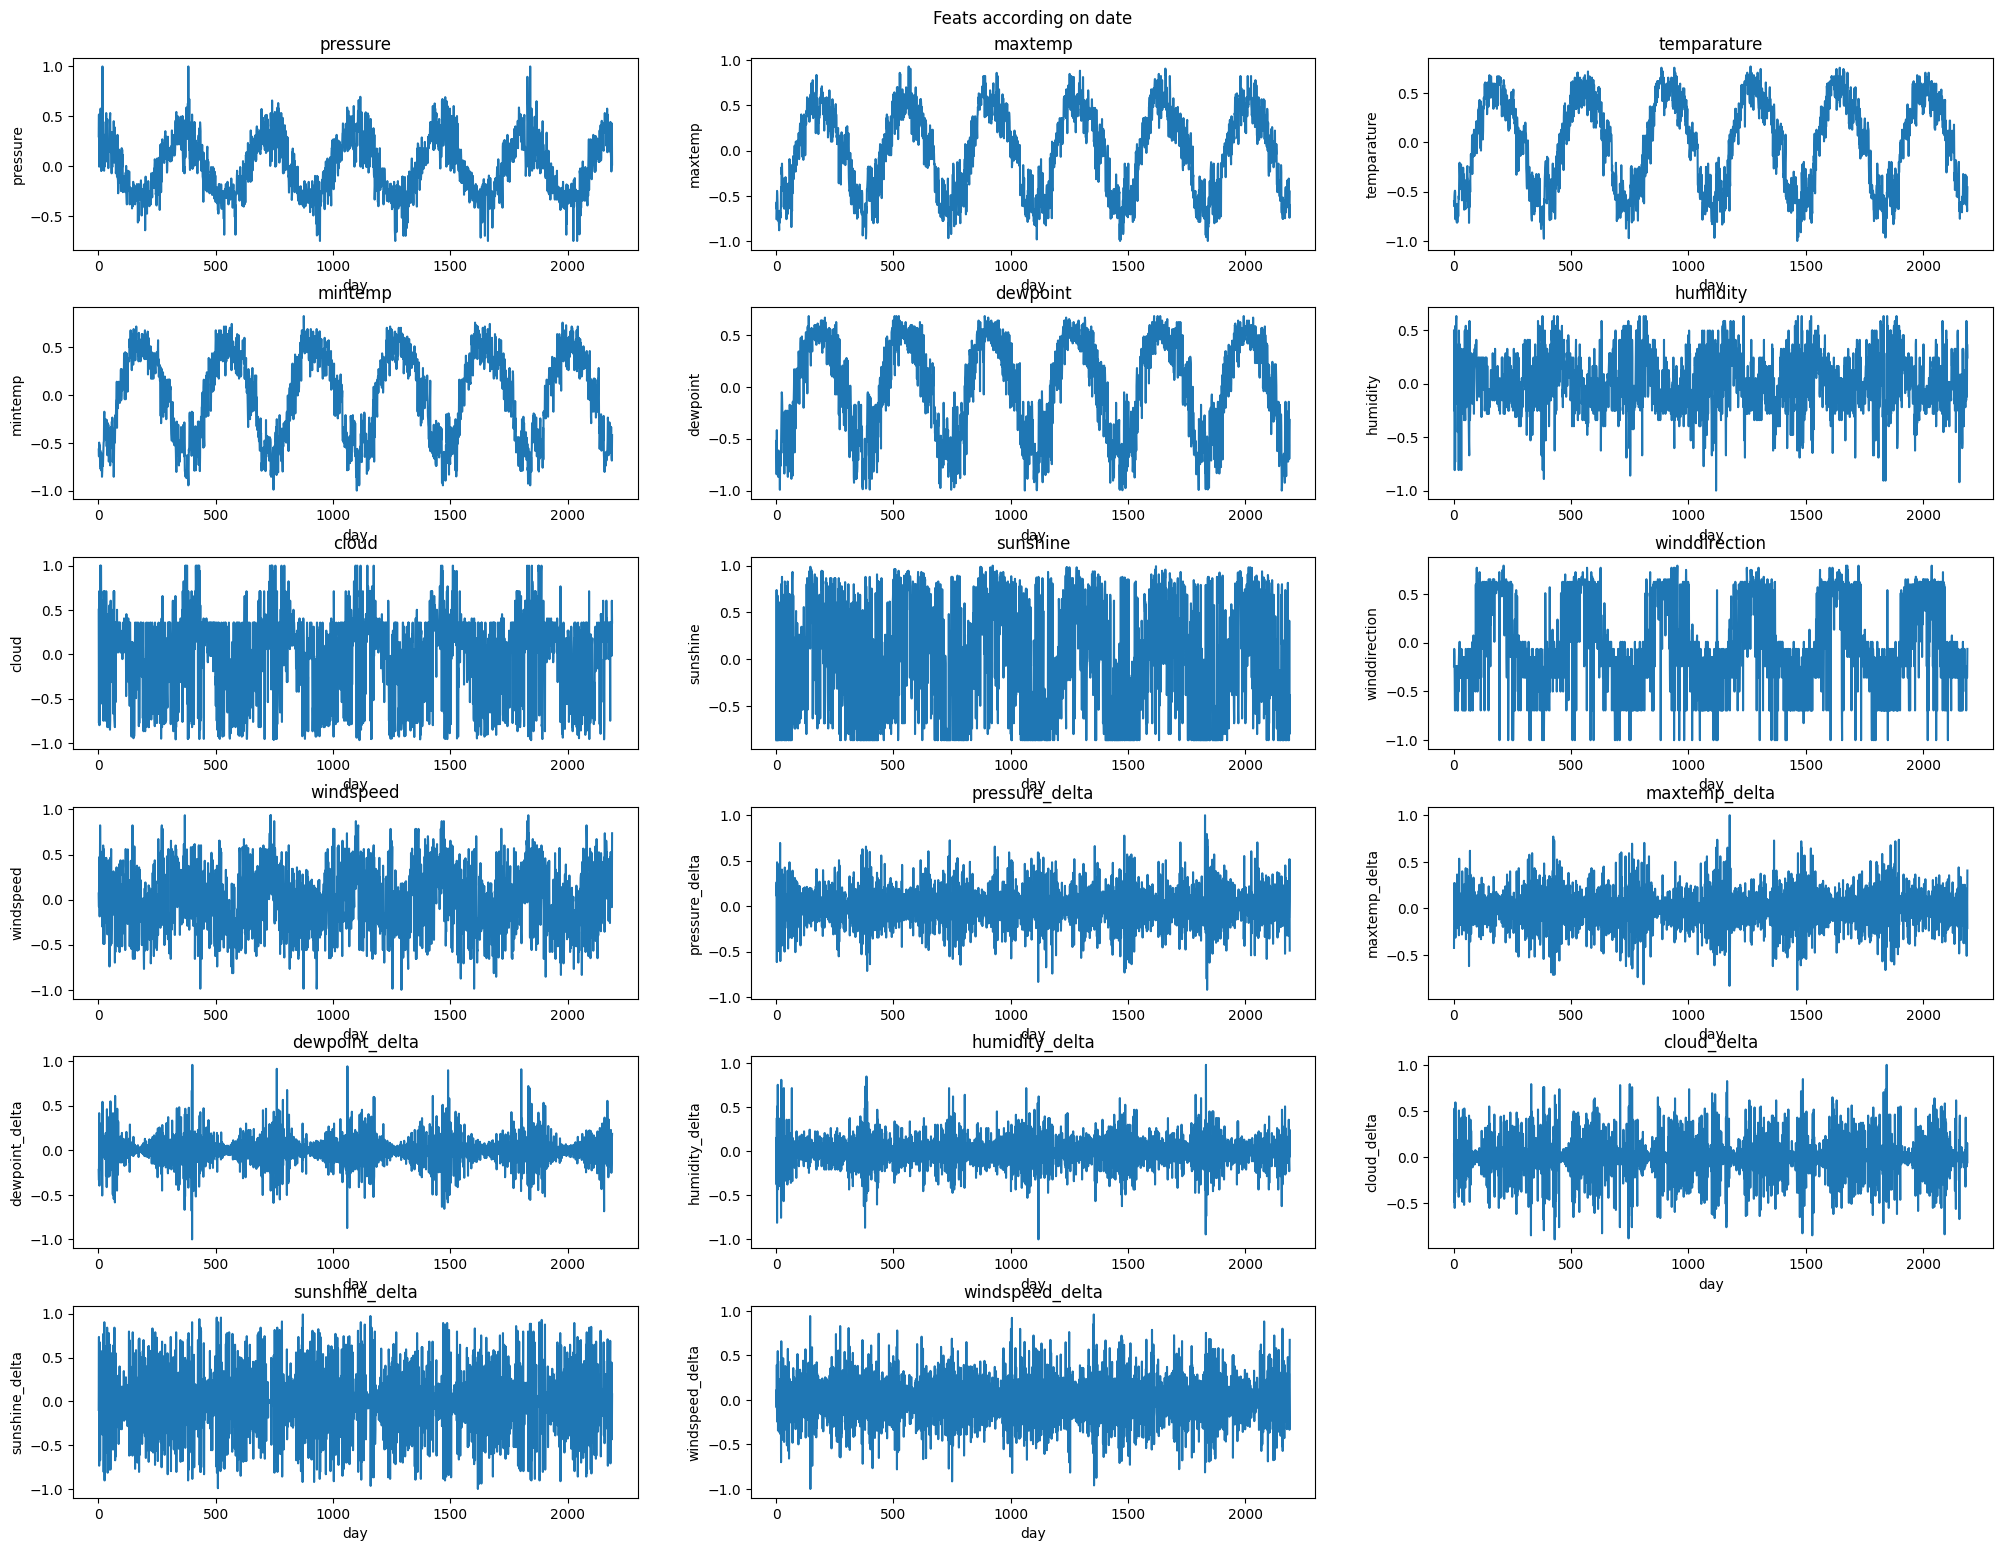

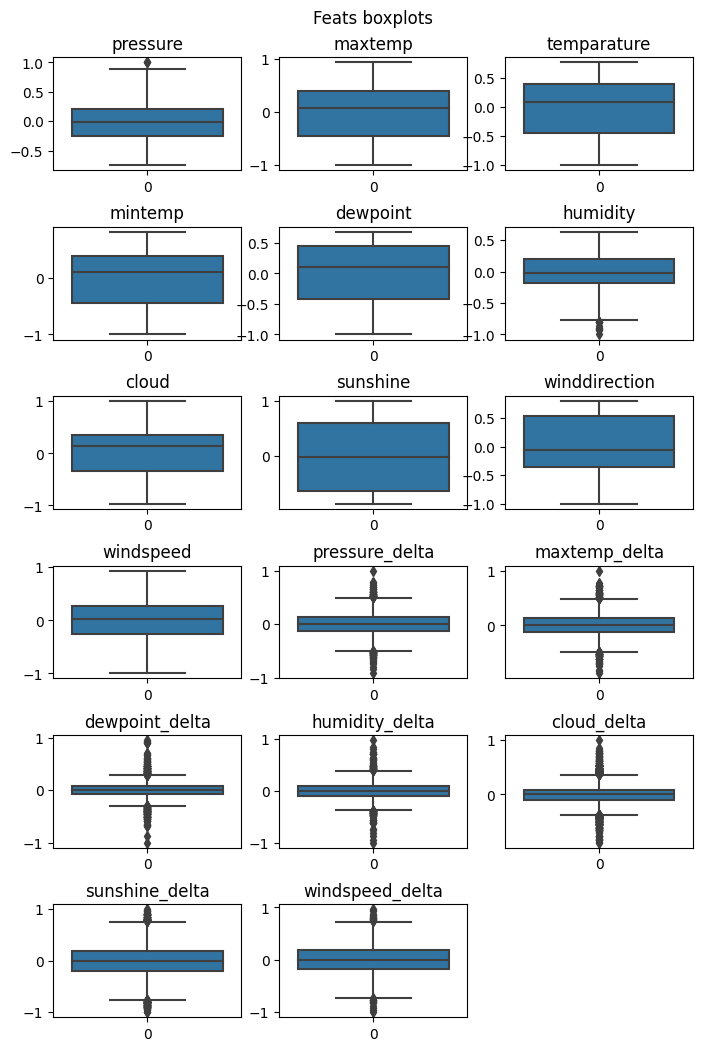

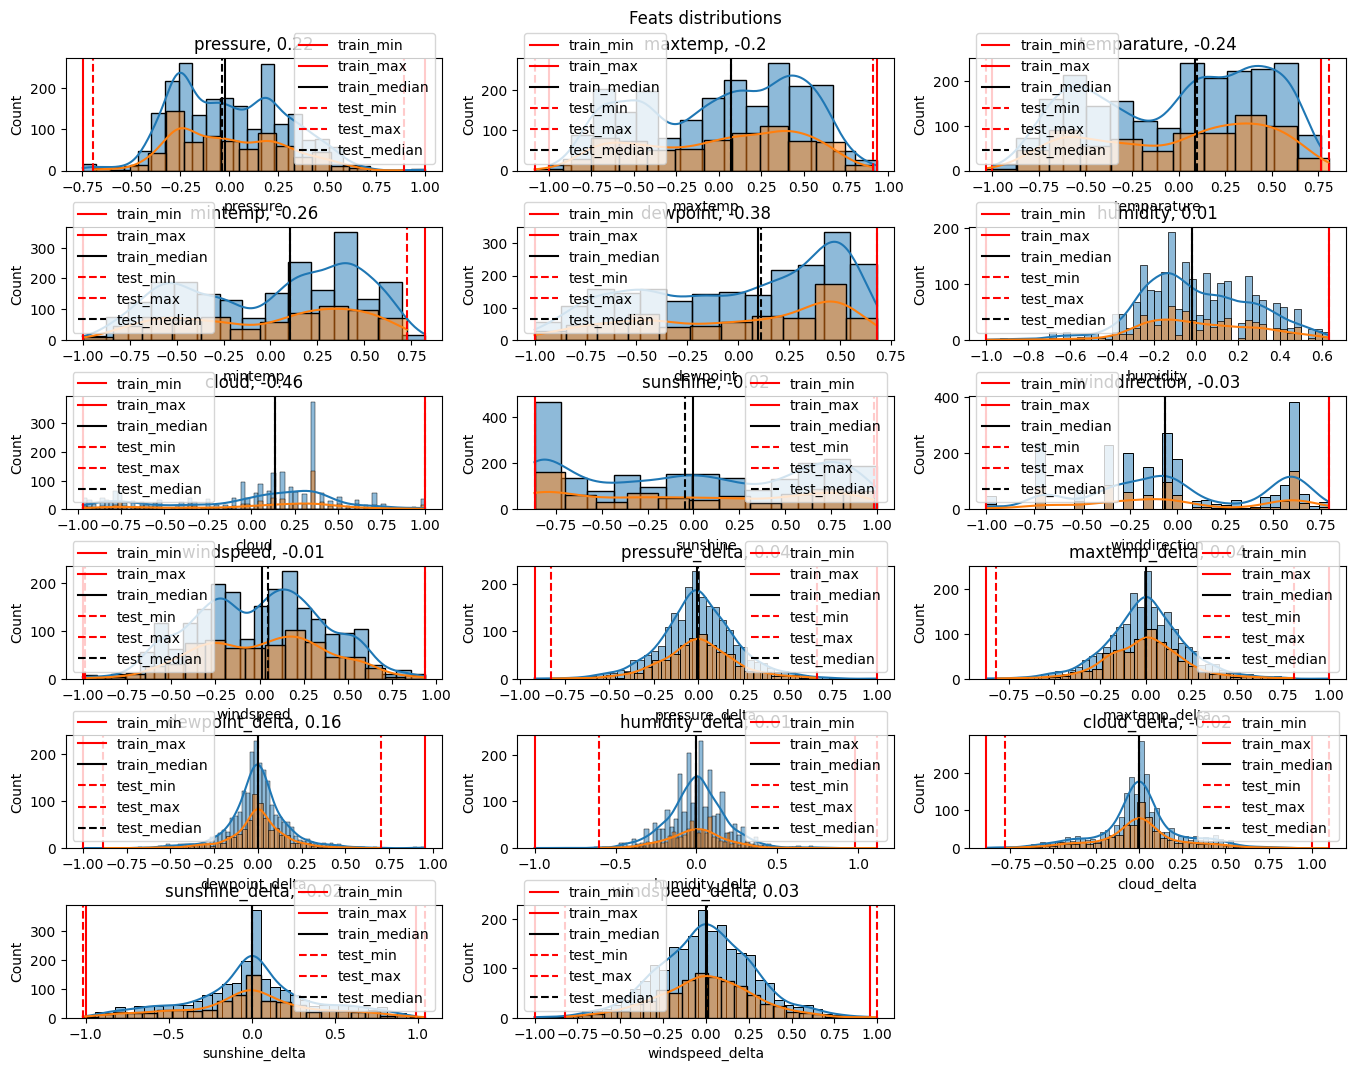

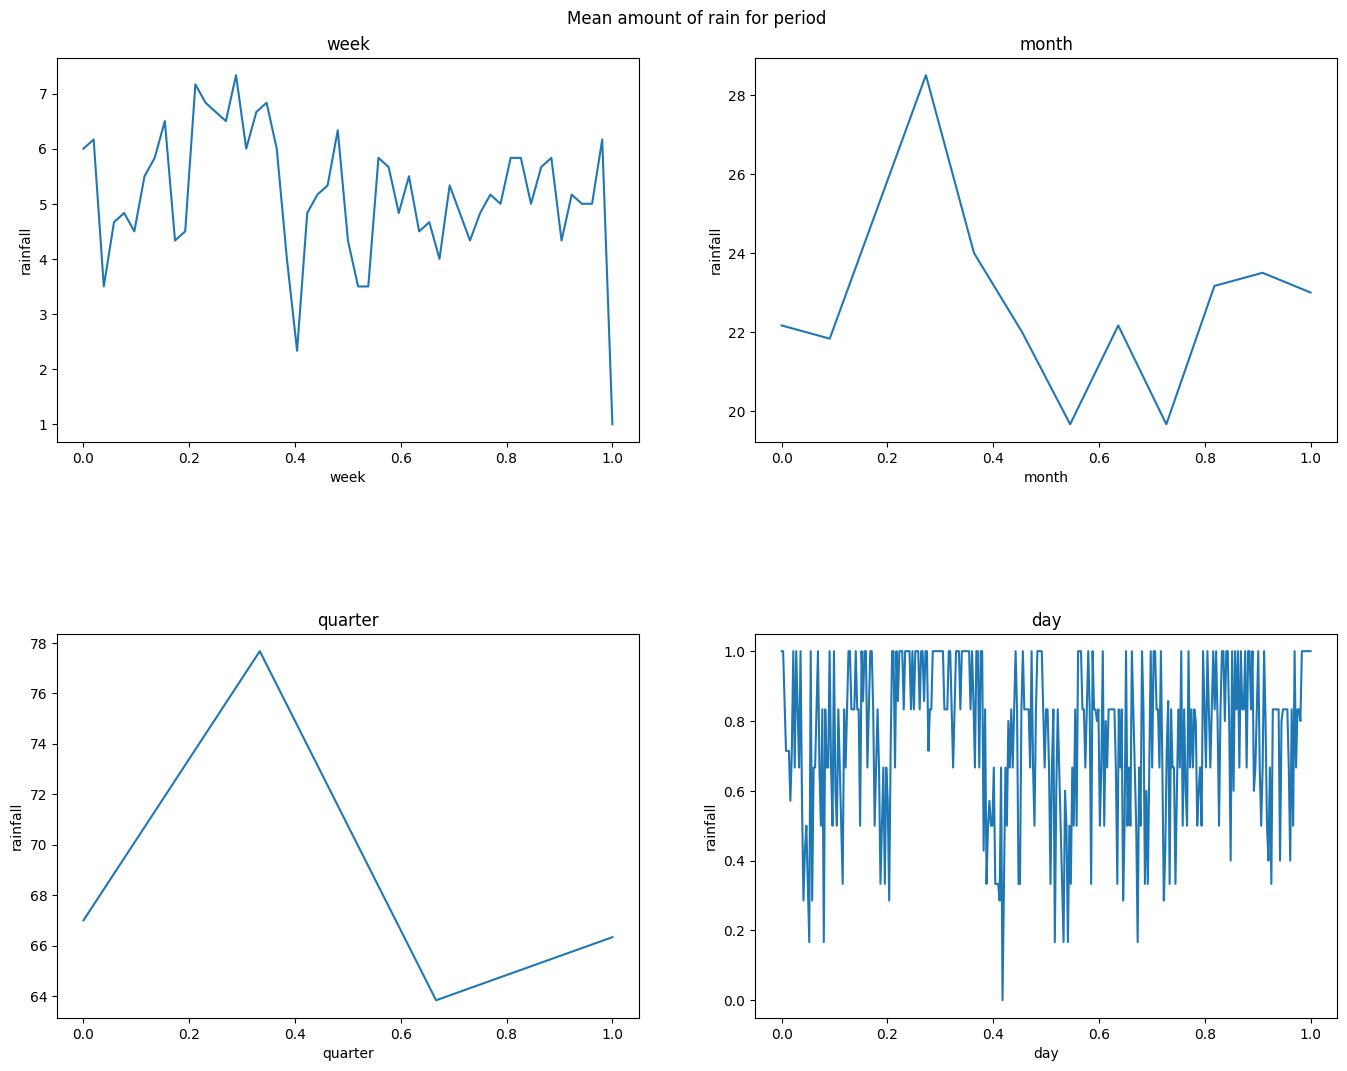

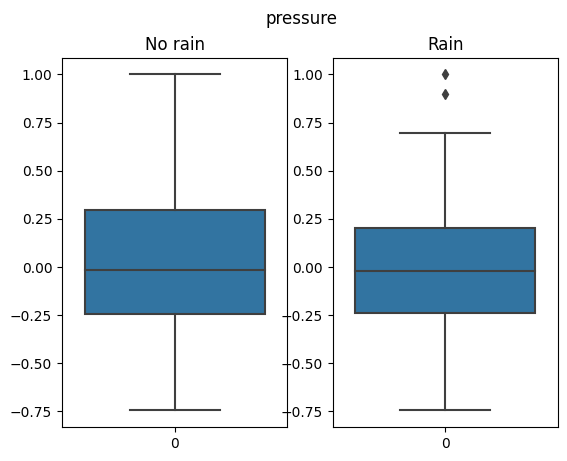

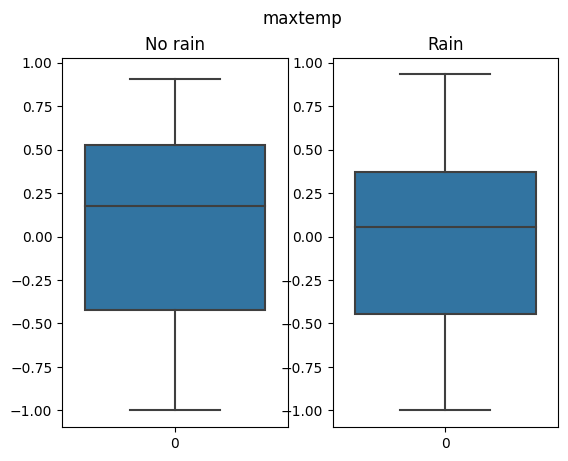

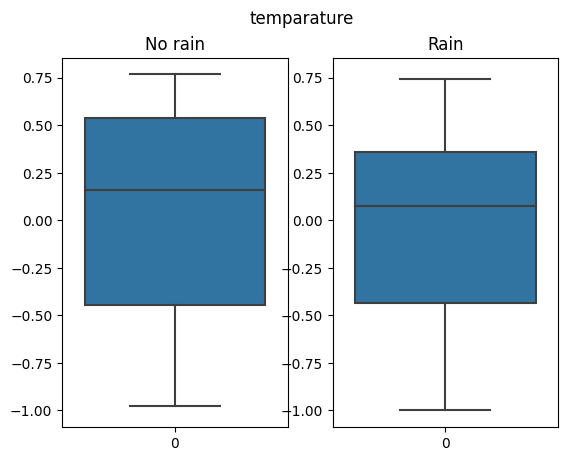

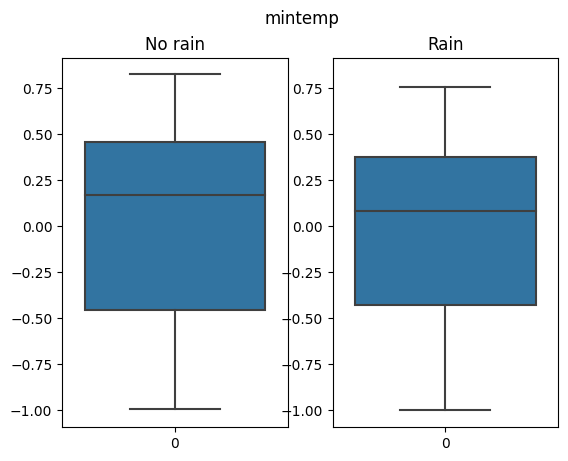

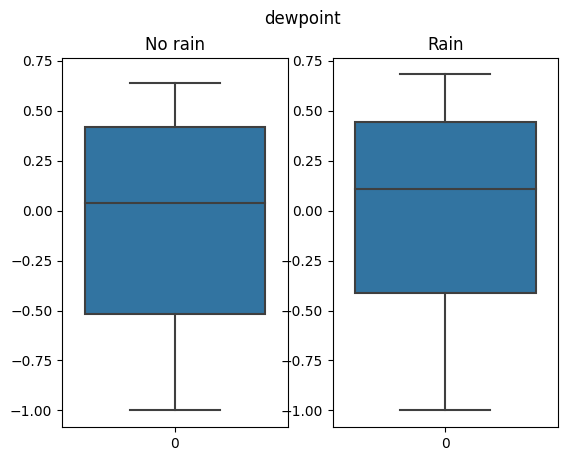

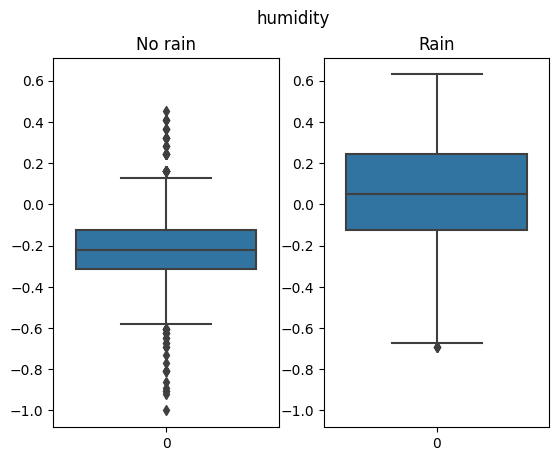

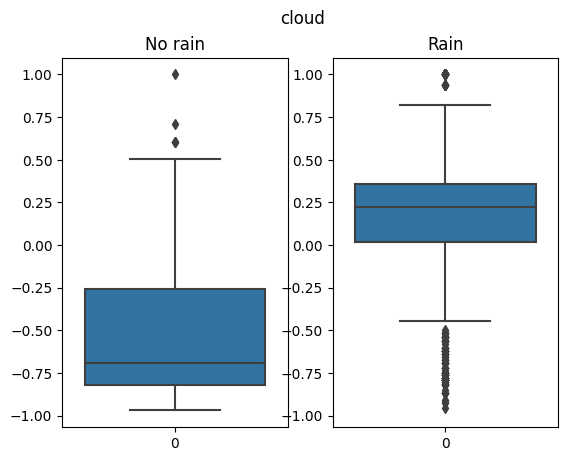

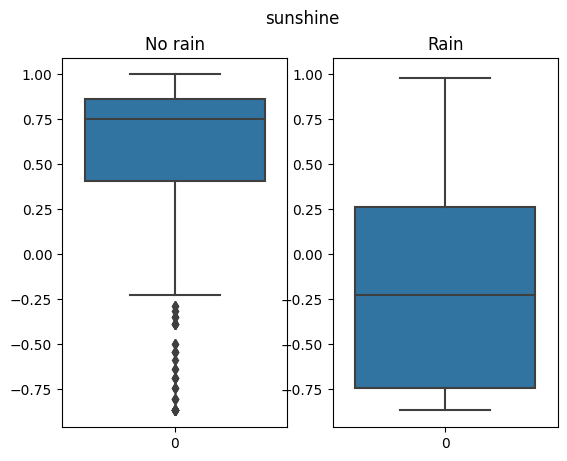

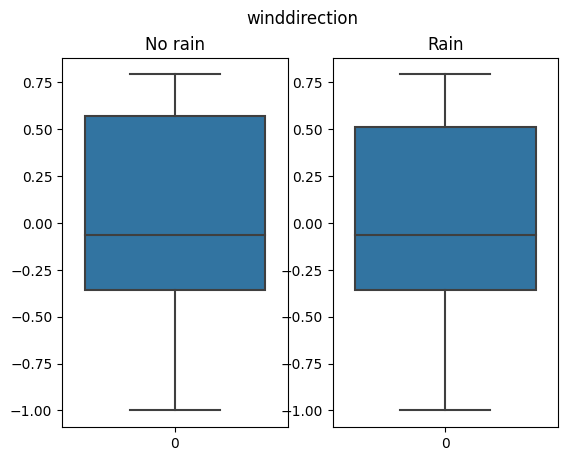

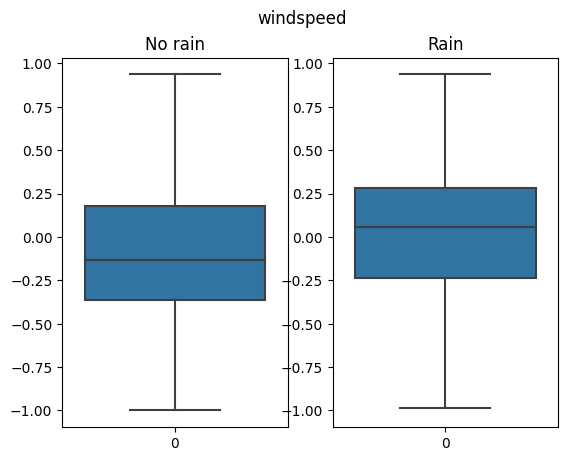

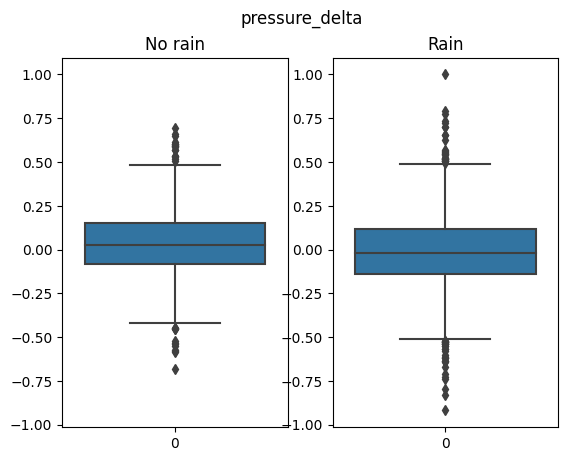

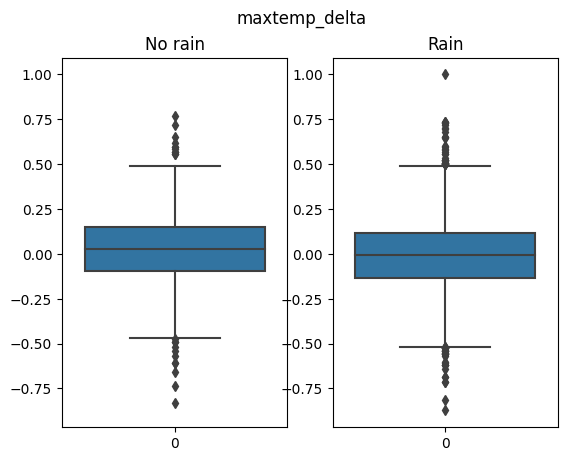

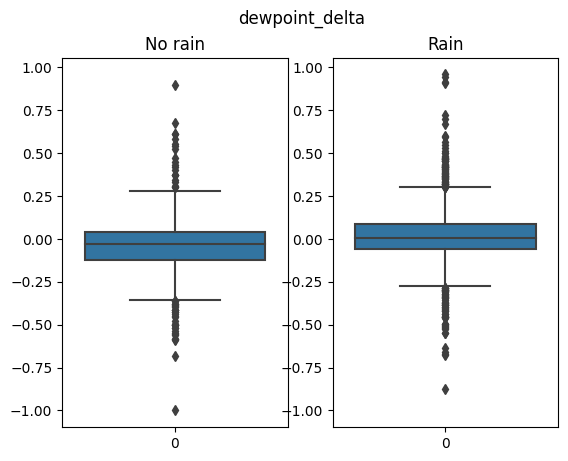

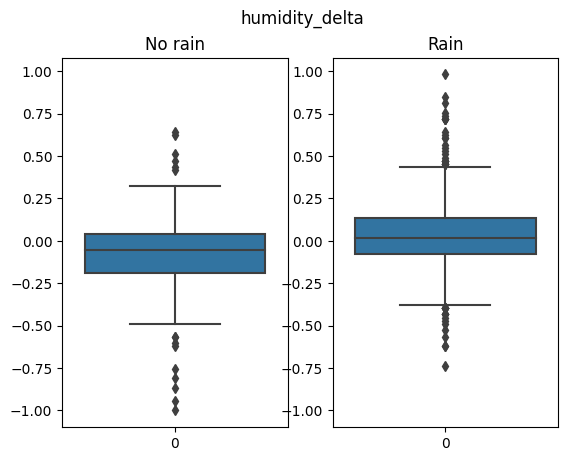

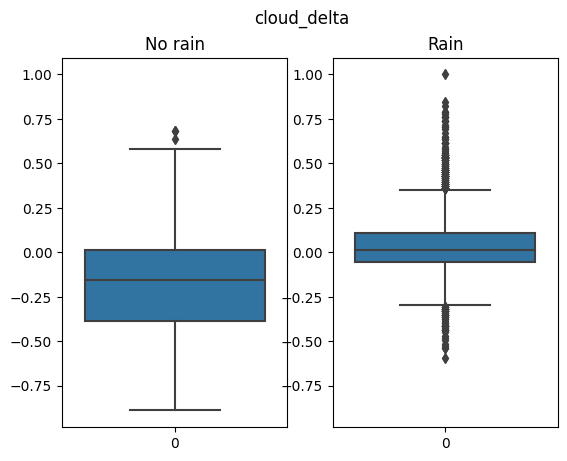

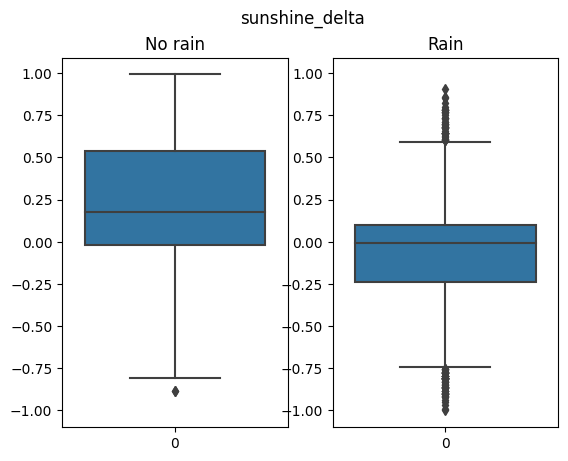

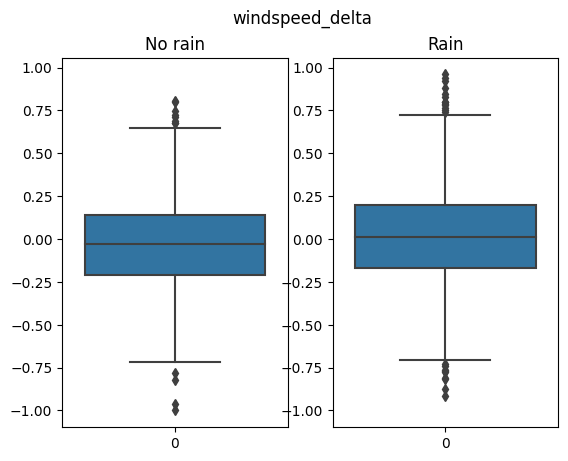

In [28]:
digest(
    TRAIN_DF_copy, TEST_DF_copy, 
    cols_for_YJ_scaler + cols_for_maxabs_scaler
)
# Дельты также имеют периодичность, что показывает периоды стабильного статуса

## Corr check

rainfall           1.000000
cloud              0.613205
humidity           0.449908
cloud_delta        0.385234
humidity_delta     0.258641
dewpoint_delta     0.138632
windspeed          0.126337
windspeed_delta    0.072119
dewpoint           0.057292
year               0.034520
winddirection      0.029183
day               -0.000017
week              -0.000394
month             -0.001879
quarter           -0.027040
mintemp           -0.046480
pressure          -0.047969
maxtemp_delta     -0.065077
temparature       -0.067107
maxtemp           -0.091793
pressure_delta    -0.097868
sunshine_delta    -0.330989
sunshine          -0.498400
Name: rainfall, dtype: float64

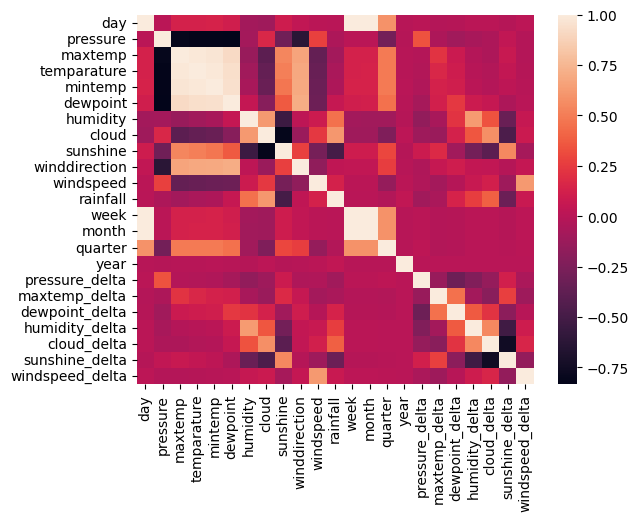

In [29]:
sns.heatmap(TRAIN_DF_copy.corr())
TRAIN_DF_copy.corr()['rainfall'].sort_values(ascending=False)

## 

# Model creating

In [30]:
CV = 5

def make_preprocess(X_train, X_test, X_val=None):
    MM_scaler = MinMaxScaler()
    MA_scaler = MaxAbsScaler()
    YJ_scaler_pipline = Pipeline(
                                    [
                                        ('YJ_transformer', PowerTransformer(method='yeo-johnson')),
                                        ('MA_scaler', MaxAbsScaler())
                                    ]
                                )
    X_train[cols_for_minmax_scaler] = MM_scaler.fit_transform(X_train[cols_for_minmax_scaler])
    X_train[cols_for_YJ_scaler]     = YJ_scaler_pipline.fit_transform(X_train[cols_for_YJ_scaler])
    X_train[cols_for_maxabs_scaler] = MA_scaler.fit_transform(X_train[cols_for_maxabs_scaler])

    X_test[cols_for_minmax_scaler] = MM_scaler.transform(X_test[cols_for_minmax_scaler])
    X_test[cols_for_YJ_scaler]     = YJ_scaler_pipline.transform(X_test[cols_for_YJ_scaler])
    X_test[cols_for_maxabs_scaler] = MA_scaler.transform(X_test[cols_for_maxabs_scaler])
    
    if X_val is not None:
        X_val[cols_for_minmax_scaler] = MM_scaler.transform(X_val[cols_for_minmax_scaler])
        X_val[cols_for_YJ_scaler]     = YJ_scaler_pipline.transform(X_val[cols_for_YJ_scaler])
        X_val[cols_for_maxabs_scaler] = MA_scaler.transform(X_val[cols_for_maxabs_scaler])
        return X_train, X_test, X_val

    return X_train, X_test

In [31]:
# def objective_xgb(trial):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 10),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
#         'objective': 'binary:logistic',
#         # 'tree_method':"hist",
#         # 'device':"cuda"
#     }
#     metrics = []
#     for idx in range(CV):
#         Xy = TRAIN_DF.copy()
#         X = TRAIN_DF.drop('rainfall', axis=1)
#         y = TRAIN_DF['rainfall']
        
#         X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
#         X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test)
        
#         X_train, X_test, X_val = make_preprocess(X_train, X_test, X_val)
        
#         model = XGBClassifier(random_state=42, **param)
#         model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=['logloss', 'auc'], verbose=False)

#         y_test_pred = model.predict_proba(X_test)
#         metrics.append(roc_auc_score(y_test.values, y_test_pred[:, 1]))
       
#     return np.mean(metrics)

# study_xgb = optuna.create_study(direction='maximize')
# study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

# best_params_xgb = study_xgb.best_params
# print("Best XGBoost Parameters:", best_params_xgb)
# print(f"Best AUC: {study_xgb.best_value:.4f}")

In [32]:
# def objective_cat(trial):
#     param = {
#         'iterations': trial.suggest_int('iterations', 500, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         # 'loss_function': 'MAPE',
#         'eval_metric': 'AUC',
#         # 'task_type': "GPU",
#         # 'devices': '0-1'
#     }
#     metrics = []
#     for idx in range(CV):
#         Xy = TRAIN_DF.copy()
#         X = TRAIN_DF.drop('rainfall', axis=1)
#         y = TRAIN_DF['rainfall']
        
#         X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
#         X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test)
        
#         X_train, X_test, X_val = make_preprocess(X_train, X_test, X_val)
        
#         model = CatBoostClassifier(random_state=42, silent=True, **param)
#         model.fit(X_train, y_train, eval_set=(X_val, y_val))

#         y_test_pred = model.predict_proba(X_test)
#         metrics.append(roc_auc_score(y_test.values, y_test_pred[:, 1]))
            
#     return np.mean(metrics)
    
# study_cat = optuna.create_study(direction='maximize')
# study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=True)

# best_params_cat = study_cat.best_params
# print("Best CatBoost Parameters:", best_params_cat)
# print(f"Best MAPE: {study_cat.best_value:.4f}")

In [33]:
# def objective_lgb(trial):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
#         'max_depth': trial.suggest_int('max_depth', -1, 15), 
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
#         "verbosity": -1,
#         # 'objective':'regression',  
#         'objective':'binary',  
#         'metric':'auc',
#         # 'device': 'gpu'
#     }
#     metrics = []
#     for idx in range(CV):
#         Xy = TRAIN_DF.copy()
#         X = TRAIN_DF.drop('rainfall', axis=1)
#         y = TRAIN_DF['rainfall']
        
#         X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
#         X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test)
        
#         X_train, X_test, X_val = make_preprocess(X_train, X_test, X_val)
        
#         model = LGBMClassifier(**param)
#         model.fit(
#             X_train, y_train,
#             eval_set=[(X_val, y_val)],
#         )

#         y_test_pred = model.predict_proba(X_test)
#         metrics.append(roc_auc_score(y_test.values, y_test_pred[:, 1]))
            
#     return np.mean(metrics)

# study_lgb = optuna.create_study(direction='maximize')
# study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

# best_params_lgb = study_lgb.best_params
# print("Best LightGBM Parameters:", best_params_lgb)
# print(f"Best MAPE: {study_lgb.best_value:.4f}")

In [34]:
# print("Best XGBoost Parameters:", best_params_xgb)
# print("Best CatBoost Parameters:", best_params_cat)
# print("Best LightGBM Parameters:", best_params_lgb)

In [35]:
best_params_xgb = {'n_estimators': 1157, 'learning_rate': 0.16441318927272444, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7934752776850366, 'colsample_bytree': 0.8044094430819003, 'gamma': 9.354160387228072, 'reg_alpha': 5.171509850268951, 'reg_lambda': 0.00011194933810301051}
best_params_cat = {'iterations': 944, 'learning_rate': 0.0321411293416033, 'depth': 9, 'l2_leaf_reg': 0.002307639872967494, 'bagging_temperature': 0.9990525376782786, 'border_count': 186}
best_params_lgb = {'n_estimators': 110, 'learning_rate': 0.22802247855424412, 'max_depth': -1, 'num_leaves': 28, 'min_child_samples': 15, 'subsample': 0.6354909592270955, 'colsample_bytree': 0.6599749723867292, 'reg_alpha': 0.3734562784352092, 'reg_lambda': 7.820032630988374}

In [57]:
Xy = TRAIN_DF.copy()
X = TRAIN_DF.drop('rainfall', axis=1)
y = TRAIN_DF['rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, random_state=42)

X_train, X_test, X_val = make_preprocess(X_train, X_test, X_val)

xgb_model = XGBClassifier(random_state=42, **best_params_xgb)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=['logloss', 'auc'], verbose=False)

cat_model = CatBoostClassifier(random_state=42, silent=True, **best_params_cat)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

lgb_model = LGBMClassifier(**best_params_lgb)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],)

y_test_pred = xgb_model.predict_proba(X_test)
print('xgb', roc_auc_score(y_test.values, y_test_pred[:, 1]))

y_test_pred = cat_model.predict_proba(X_test)
print('cat', roc_auc_score(y_test.values, y_test_pred[:, 1]))

y_test_pred = lgb_model.predict_proba(X_test)
print('lgb', roc_auc_score(y_test.values, y_test_pred[:, 1]))

stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model), 
        ('cat', cat_model), 
        ('lgb', lgb_model)
    ],
    final_estimator=LogisticRegression(),
    cv='prefit', 
    stack_method='auto'
)
stacking_model.fit(X_train, y_train)
y_test_pred = stacking_model.predict_proba(X_test)
print('stk', roc_auc_score(y_test.values, y_test_pred[:, 1]))

[LightGBM] [Info] Number of positive: 1236, number of negative: 405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3022
[LightGBM] [Info] Number of data points in the train set: 1641, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753199 -> initscore=1.115749
[LightGBM] [Info] Start training from score 1.115749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
xgb 0.8358081096516276
cat 0.7766990291262135
lgb 0.8015419760137065
stk 0.7904054825813821


In [58]:
xgb_model = XGBClassifier(random_state=42, **best_params_xgb)
# xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=['logloss', 'auc'], verbose=False)

cat_model = CatBoostClassifier(random_state=42, silent=True, **best_params_cat)
# cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

lgb_model = LGBMClassifier(**best_params_lgb)
# lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],)

# y_test_pred = xgb_model.predict_proba(X_test)
# print('xgb', roc_auc_score(y_test.values, y_test_pred[:, 1]))

# y_test_pred = cat_model.predict_proba(X_test)
# print('cat', roc_auc_score(y_test.values, y_test_pred[:, 1]))

# y_test_pred = lgb_model.predict_proba(X_test)
# print('lgb', roc_auc_score(y_test.values, y_test_pred[:, 1]))

voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model), 
        ('cat', cat_model), 
        ('lgb', lgb_model)],
    voting='soft'
)

voting_model.fit(X_train, y_train)

y_test_pred = voting_model.predict_proba(X_test)
print('vtk soft', roc_auc_score(y_test.values, y_test_pred[:, 1]))

[LightGBM] [Info] Number of positive: 1236, number of negative: 405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3022
[LightGBM] [Info] Number of data points in the train set: 1641, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753199 -> initscore=1.115749
[LightGBM] [Info] Start training from score 1.115749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
vtk soft 0.821245002855511


## final

In [59]:
Xy = TRAIN_DF.copy()
X_train = TRAIN_DF.drop('rainfall', axis=1)
y_train = TRAIN_DF['rainfall']
X_test = TEST_DF.copy()

X_train, X_test = make_preprocess(X_train, X_test)

xgb_model = XGBClassifier(random_state=42, **best_params_xgb)
cat_model = CatBoostClassifier(random_state=42, silent=True, **best_params_cat)
lgb_model = LGBMClassifier(**best_params_lgb)


voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model), 
        ('cat', cat_model), 
        ('lgb', lgb_model)],
    voting='soft'
)

voting_model.fit(X_train, y_train)

y_test_pred = voting_model.predict_proba(X_test)
print(y_test_pred)

[LightGBM] [Info] Number of positive: 1649, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 2189, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753312 -> initscore=1.116355
[LightGBM] [Info] Start training from score 1.116355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[[0.02481318 0.97518682]
 [0.01745231 0.98254769]
 [0.0314234  0.9685766 ]
 ...
 [0.01783193 0.98216807]
 [0.01803977 0.98196023]
 [0.03754891 0.96245109]]


<Axes: ylabel='Count'>

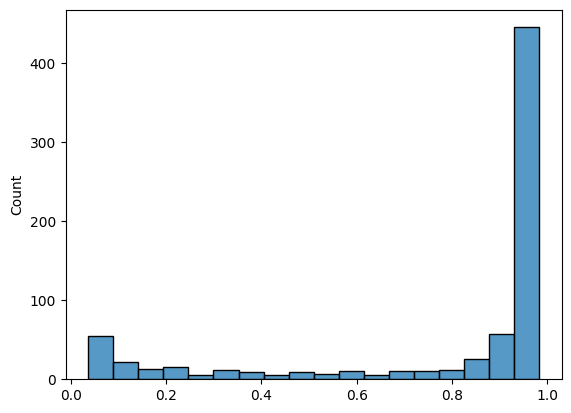

In [60]:
sns.histplot(y_test_pred[:, 1])

In [66]:
y_re = TEST_DF.copy()
y_re['rainfall'] = y_test_pred[:, 1]
y_re = y_re['rainfall']
y_re.to_csv('result.csv')
# y_re